**DATA ANALYSIS**

In [1]:
import pandas as pd
import numpy as np
import io
import requests
import os
import zipfile
import urllib.request
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.ticker import PercentFormatter #plot as percentage
import seaborn #plot density and histogram at the same time
# Set directory where files are downloaded to. Chdir has to be changed in order to run on another computer
os.chdir('C:\\Users\justu\\Desktop\\Masterarbeit\\Data\\CE') #change this to the folder where the data set is stored, all the results will be saved in the same folder
os.getcwd()

'C:\\Users\\justu\\Desktop\\Masterarbeit\\Data\\CE'

**Prepare Data** (necessary for part1 and part2)

In [2]:
fs08 = pd.read_csv(os.getcwd()+'\\fs08.csv').set_index('CustID')
#identifier
TIME = ['QINTRVMO', 'QINTRVYR', 'rbtmo_1', 'rbtmo_2', 'diff_1', 'diff_2']
ID = ['NEWID']

#dependent variables
CONS = ['FD','SND','ND','DUR','TOT']
FUTCONS = ['fut_' + c for c in CONS]
LRUNCONS = ['lrun_' + c for c in CONS]

for i in range(len(LRUNCONS)):
    fs08[LRUNCONS[i]] = fs08[[CONS[i],FUTCONS[i]]].sum(axis=1)

#explanatory variables
DEMO = ['age', 'adults', 'PERSLT18', 'MARITAL1', 'CUTENURE'] #exclude , 'FINCBTAX'
    #age; number of adults; people below 18; marital status; housing tenure; income in the last 12 months
DEMO2 = ['FSALARYM', 'FINCBTXM'] 
    #FSALARYM: income from salary and wages, CKBKACTX: balance/market value in balance accounts/brookerage accounts;    
    #FINCBTXM: Total amount of family income before taxes (Imputed or collected data); (relevant demographics available for the second stimulus only)
ASSETS = ['valid_finassets','finassets']
    # finassets: sum of 1) SAVACCTX (Total balance/market value (including interest earned) CU had in savings accounts in banks, savings and loans,
                         #credit unions, etc., as of the last day of previous month;)
                # and    2)CKBKACTX (Total balance or market value (including interest earned) CU had in checking accounts, brokerage accounts, 
                            #and other similar accounts as of the last day of the previous month
MORTGAGE = ['morgpayment', 'qblncm1x_sum', 'qescrowx_sum', 'timeleft'] #exclude , 'orgmrtx_sum',
    #morgpayment: morgage payment per month; qblncm1x_sum: sum of principal balances outstanding at the beginning of month M1; orgmrtx_sum: sum of mortgage amounts;
    #qescrowx_sum: sum of last regular escrow payments; timeleft: maximum time left on mortgage payment
EDUC = ['educ_nodegree','educ_highschool','educ_higher'] #
#sample split
RBT = ['rbtamt', 'rbtamt_chk', 'rbtamt_e']
LAGRBT = ['last_' + var for var in RBT] #lagged variables
FUTRBT = ['fut_' + var for var in RBT] #future variables

for m in MORTGAGE:
    fs08.loc[fs08[m].isna(),m]=0
        


fs08 = fs08[TIME + ID + CONS + DEMO + DEMO2 + ASSETS + MORTGAGE + RBT + ['rbtamt_1','rbtamt_2'] + LAGRBT + FUTRBT + FUTCONS + LRUNCONS + EDUC] #+ CHGCONS + LAGCONS 
#fs08 = fs08.loc[fs08['timeleft']>0,:]
fs08 = pd.get_dummies(fs08, columns=['CUTENURE','MARITAL1']) #change categorical variables to dummy variables

DEMO = [s for s in DEMO if s!='CUTENURE' if s!='MARITAL1'] + ['CUTENURE' + f'_{j}' for j in list(range(1,6)) if j!=3] +['MARITAL1' + f'_{j}' for j in list(range(1,5))]

Generate the average rebate amount per individual 

In [3]:
fs08['rbtamt_idmean'] = 0
fs08['rbtamt_idmean'] = fs08.groupby('CustID')['rbtamt'].transform('mean')
fs08['rbt_count'] = 0
fs08['rbt_count'] = fs08.groupby('CustID')['rbtamt'].transform('count')

#
#sometimes individuals give information of rebate receipt preceding (following) three months of the first (last) interview.
#Wherever this is the case, the average rebate should be the weighted mean of rebates received before (after) the relevant time and the actual rebate 

fs08['rbtamt_idmean'] = np.where((fs08['last_rbtamt']>0) & (fs08['NEWID'].isin(fs08.groupby('CustID')['NEWID'].first())),
                                 1/(1+fs08['rbt_count'])*(fs08['last_rbtamt']+fs08['rbtamt_idmean']), fs08['rbtamt_idmean']) #weighted mean,  & (fs08['rbtamt_idmean']>0)
index = fs08.index[(fs08['last_rbtamt']>0) & (fs08['NEWID'].isin(fs08.groupby('CustID')['NEWID'].first()))].tolist() # & (fs08['rbtamt_idmean']>0)
fs08.loc[index,'rbtamt_idmean'] = fs08.loc[index,:].groupby('CustID')['rbtamt_idmean'].transform('first') #change for all entries for a given individual


fs08['rbtamt_idmean'] = np.where((fs08['fut_rbtamt']>0) & (fs08['NEWID'].isin(fs08.groupby('CustID')['NEWID'].last())),
                                 1/(1+fs08['rbt_count'])*(fs08['fut_rbtamt']+fs08['rbtamt_idmean']), fs08['rbtamt_idmean']) #weighted mean  & (fs08['rbtamt_idmean']>0)
index = fs08.index[(fs08['fut_rbtamt']>0)  & (fs08['NEWID'].isin(fs08.groupby('CustID')['NEWID'].last()))].tolist() #& (fs08['rbtamt_idmean']>0)
fs08.loc[index,'rbtamt_idmean'] = fs08.loc[index,:].groupby('CustID')['rbtamt_idmean'].transform('last')  #change for all entries for a given individual
#display(fs08.loc[index, ['rbtamt_idmean', 'rbtamt', 'fut_rbtamt', 'last_rbtamt']])

#wherever there is no entry for rebates received in the relevant time period but when there were rebates receivde in the past (future) change mean to the value
index = fs08.index[(fs08['fut_rbtamt']>0) & (fs08['rbtamt_idmean'].isna()) & (fs08['NEWID'].isin(fs08.groupby('CustID')['NEWID'].last()))].tolist() #                                                                               
fs08['rbtamt_idmean'] = np.where((fs08['fut_rbtamt']>0) & (fs08['rbtamt_idmean'].isna()) & (fs08['NEWID'].isin(fs08.groupby('CustID')['NEWID'].last())),
                                 fs08['fut_rbtamt'], fs08['rbtamt_idmean'])
fs08.loc[index,'rbtamt_idmean'] = fs08.loc[index,:].groupby('CustID')['rbtamt_idmean'].transform('last')

index = fs08.index[(fs08['last_rbtamt']>0) & (fs08['rbtamt_idmean'].isna()) & (fs08['NEWID'].isin(fs08.groupby('CustID')['NEWID'].first()))].tolist()
fs08['rbtamt_idmean'] = np.where((fs08['last_rbtamt']>0) & (fs08['rbtamt_idmean'].isna()) & (fs08['NEWID'].isin(fs08.groupby('CustID')['NEWID'].first())), 
                                fs08['last_rbtamt'], fs08['rbtamt_idmean'])
fs08.loc[index,'rbtamt_idmean'] = fs08.loc[index,:].groupby('CustID')['rbtamt_idmean'].transform('first')


fs08['rbt_flag'] = 0 
fs08.loc[(fs08['rbtamt']>0) | (fs08['fut_rbtamt']>0) | (fs08['last_rbtamt']>0) ,'rbt_flag'] = 1
fs08['rbt_flag'] = fs08.groupby('CustID')['rbt_flag'].transform('sum')
fs08.loc[fs08['rbt_flag']>0, 'rbt_flag'] = 1
fs08 = fs08.loc[fs08['rbt_flag']==1]


index = fs08.index[fs08['rbtamt_idmean'].isna()].tolist()
index = list(set(index))
fs08.loc[index, 'rbtamt_idmean'] = fs08.loc[index,'fut_rbtamt']
fs08.loc[(fs08['fut_rbtamt']>0) & (fs08['rbtamt_idmean'].isna()), 'rbtamt_idmean' ] = fs08.loc[(fs08['fut_rbtamt']>0) & (fs08['rbtamt_idmean'].isna()), 'fut_rbtamt' ]
fs08.loc[(fs08['last_rbtamt']>0) & (fs08['rbtamt_idmean'].isna()), 'rbtamt_idmean' ] = fs08.loc[(fs08['last_rbtamt']>0) & (fs08['rbtamt_idmean'].isna()), 'last_rbtamt' ]

fs08.loc[index,'rbtamt_idmean'] = fs08.loc[index,:].groupby('CustID')['rbtamt_idmean'].transform('mean')


Drop observations, impute values for financial liquidity

In [4]:

for i in range(len(RBT)):
    fs08.loc[fs08[RBT[i]]==0, RBT[i]] = np.nan
    fs08.loc[fs08[LAGRBT[i]]==0, LAGRBT[i]] = np.nan
    fs08.loc[fs08[FUTRBT[i]]==0, FUTRBT[i]] = np.nan
    #fs08.loc[(fs08[LAGRBT[i]]==0) | (fs08[LAGRBT[i]].isna()), LAGRBT[i]] =  fs08.loc[(fs08[LAGRBT[i]]==0) | (fs08[LAGRBT[i]].isna())].groupby('CustID')[RBT[i]].shift(-1) 
    fs08.loc[(fs08[FUTRBT[i]]==0) | (fs08[FUTRBT[i]].isna()), FUTRBT[i]] =  fs08.loc[(fs08[FUTRBT[i]]==0) | (fs08[FUTRBT[i]].isna())].groupby('CustID')[RBT[i]].shift(-1) 



fs08 = fs08.reset_index()

#Iterative imputation for financial liquidity
#explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer


fs08 = fs08.dropna(subset=CONS+DEMO+DEMO2+MORTGAGE) #Keep only observations that have all info on explanatory variables, dropping missing values on mortgage lowers the sample to half 


fs08_finit = fs08.copy()
fs08_finit = fs08_finit[ ID + CONS + DEMO + DEMO2 + ASSETS + MORTGAGE +  LRUNCONS + EDUC]
#fs08_finit = fs08_finit.loc[:,CONS+DEMO+DEMO2+MORTGAGE+['CustID','NEWID','finassets']]
labels = list(fs08_finit.columns)
imp_mean = IterativeImputer(random_state=0) #use python package iterative imputer
imp_mean.fit(fs08_finit[2:])
fs08_finit = pd.DataFrame(imp_mean.transform(fs08_finit),columns=labels)
fs08_finit = fs08_finit.loc[:,['finassets','NEWID']]
fs08_finit = fs08_finit.rename(columns={'finassets':'finassets_it'})

fs08 = pd.merge(fs08.sort_values(by = ['NEWID']).reset_index(), fs08_finit.sort_values(by = ['NEWID']).reset_index(), how = 'left', on = 'NEWID', validate = '1:1')
fs08 = fs08.drop(columns=['index_x','index_y']) 
ASSETS = ['valid_finassets','finassets', 'finassets_it' ]


Generate treatment and control groups

In [5]:
#generate treatment group:
fs08['treat1'] = 0 
fs08.loc[fs08['rbtamt'].notna(),'treat1'] = 1 #all entries with actual info on rebate are in the treatment group

#three different control groups:
#control group 1: those who didn't receive the rebate in the given month
fs08['cont1'] = 0
fs08.loc[fs08['rbtamt'].isna(), 'cont1'] = 1

#control group 2: drop one time period after receipt of rebate, as part of rebate might've been consumed one time period after
fs08['cont2'] = 0 
fs08['rbt_flag'] = 0 
fs08.loc[fs08['rbtamt']>0,'rbt_flag'] = 1 #identifier for rebate
fs08['rbt_flag_lag'] = fs08.groupby('CustID')['rbt_flag'].shift(1) #identifier for rebate a period before (lag)
fs08.loc[fs08['rbt_flag_lag']==1,'rbt_flag']=1 #change rebate identifier so it capture now if a rebate was received this period or the period before
fs08.loc[(fs08['rbtamt'].isna()) & (fs08['rbt_flag']==0), 'cont2'] = 1 #those who didn't receive a rebate now or a period before are in the control group

#treatment 2: all individuals who received a rebate last time period. This group should be compared to control group 2 only
fs08['treat2'] = 0
fs08.loc[(fs08['cont2']==0) & (fs08['treat1']==0),'treat2'] = 1
fs08.loc[(fs08['last_rbtamt']>0) & (fs08['rbtamt'].isna()), 'treat2'] = 1

#treatment 3: long run consumption response: all individuals who received a rebate in this period and where the rebate interview is not the last
fs08['treat3'] = 0
fs08.loc[(fs08['rbtamt']>0) & (fs08[FUTCONS[0]].notna()), 'treat3'] = 1

#control 3: long-run consumption: those who haven't received a rebate two periods from current period and have information on consumption for next period as well
fs08['cont4'] = 0
fs08.loc[(fs08['cont2']==1) & (fs08[FUTCONS[0]].notna()),'cont4'] = 1

#control 4: those who haven't received the rebate yet
fs08['cont3'] = 0 
fs08['rbt_flag'] = fs08.groupby('CustID')['rbt_flag'].transform('cumsum') #starts counting from the point on which the first rebate was received
fs08.loc[(fs08['rbtamt'].isna()) & (fs08['rbt_flag']==0),'cont3'] = 1 

Drop observations

In [6]:
fs08_cap = fs08[(np.abs(stats.zscore(fs08.loc[:,CONS+LRUNCONS])) < 3).all(axis=1)] #drop outliers
fs08_cap = fs08_cap.loc[fs08_cap['FD']>0] #there are still two observations where food consumption is zero; drop bc of common sense
fs08_cap = fs08_cap.loc[fs08['ND']>0]

**Part 1: Descriptive statistics** (part 1 and part 2 cn be run seperately)

1.2 Take a look at the explanatory variables used for random forest algorithm

In [83]:

MORTGAGE = ['morgpayment', 'qblncm1x_sum', 'qescrowx_sum', 'timeleft'] #'orgmrtx_sum',
expvars = DEMO+DEMO2+ASSETS+MORTGAGE+EDUC+['rbtamt','rbtamt_idmean']

#income table
for exp in expvars:
    if exp == DEMO[0]:
        des = fs08_cap.loc[fs08_cap['treat1']==1,exp].describe()
        display(des)
        des = pd.concat([des, fs08_cap.loc[fs08_cap['cont1']==1,exp].describe()], axis=1, join='inner')
    else:
        for g in ['treat1','cont1']:
            if exp in MORTGAGE:
                des = pd.concat([des, fs08_cap.loc[(fs08[g]==1)&(fs08[exp]>0),exp].describe()], axis=1, join='inner')
            else:
                des = pd.concat([des, fs08_cap.loc[fs08[g]==1,exp].describe()], axis=1, join='inner')

index1 = [ i for i in expvars for reps in range(2) ]
index2 = ['treat1','cont1']*int((len(index1)/2))
tuples = list(zip(index1,index2))
des.columns = pd.MultiIndex.from_tuples(tuples) 
des_cols = list(des)
des_cols=[i for i in des_cols if i[0] in ['FINCBTXM','finassets','finassets_it','age']]
print(des.iloc[[0,1,2,4,5,6]].to_latex(float_format="{:,.1f}".format, columns=des_cols,multicolumn_format='c')) #table1
des_cols = list(des)
des_cols = [i for i in des_cols if i[0] in ['morgpayment','qblncm1x_sum','qescrowx_sum','timeleft']]
print(des.iloc[[0,1,2,4,5,6]].to_latex(float_format="{:,.1f}".format, columns=des_cols,multicolumn_format='c')) #table2
des_cols = list(des)

count    4028.000000
mean       49.705313
std        15.572740
min        21.000000
25%        37.500000
50%        49.000000
75%        61.500000
max        84.500000
Name: age, dtype: float64

\begin{tabular}{lrrrrrrrr}
\toprule
{} & \multicolumn{2}{c}{age} & \multicolumn{2}{c}{FINCBTXM} & \multicolumn{2}{c}{finassets} & \multicolumn{2}{c}{finassets\_it} \\
{} &  treat1 &    cont1 &   treat1 &    cont1 &    treat1 &     cont1 &       treat1 &    cont1 \\
\midrule
count & 4,028.0 & 11,195.0 &  4,028.0 & 11,195.0 &     723.0 &   1,458.0 &      4,028.0 & 11,195.0 \\
mean  &    49.7 &     50.2 & 61,456.0 & 62,444.7 &  36,182.4 &  44,898.0 &     48,045.8 & 50,124.9 \\
std   &    15.6 &     15.3 & 46,710.9 & 47,227.1 & 144,797.3 & 214,301.3 &     78,665.0 & 94,903.9 \\
25\%   &    37.5 &     38.0 & 28,149.5 & 29,000.0 &     225.0 &     200.0 &      9,616.5 & 11,342.8 \\
50\%   &    49.0 &     49.0 & 50,780.5 & 52,056.0 &   2,200.0 &   2,600.0 &     30,743.0 & 31,556.1 \\
75\%   &    61.5 &     61.5 & 81,927.0 & 82,553.5 &  14,000.0 &  16,000.0 &     61,857.0 & 62,810.2 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrrrr}
\toprule
{} & \multicolumn{2}{c}{morgpayment} & \multico

In [8]:
print('Average amount of rebate received per household')
des = fs08_cap.loc[fs08_cap['cont1']==1,'rbtamt_idmean'].describe()
des = pd.concat([des, fs08_cap.loc[fs08_cap['treat1']==1,'rbtamt_idmean'].describe()], axis=1, join='inner',names=['cont1','treat1'])
des = pd.concat([des, fs08_cap.loc[fs08['rbtamt']>0,'rbtamt'].describe()], axis=1, join='inner',names=['cont1','treat1','treat1'])
tuples = [('rbtamt_mean', 'cont1'), ('rbtamt_mean', 'treat1'), ('rbtamt', 'treat1')]
des.columns = pd.MultiIndex.from_tuples(tuples)
print(des.stack().unstack(level=0).stack(level=0).to_latex(float_format="{:,.0f}".format,  columns=['count','mean','max','min','25%','75%','std'])) #table 3
#print(des1.loc[['count', 'mean', 'std', 'min','50%','max'],:].to_latex(float_format="{:,.1f}".format))


Average amount of rebate received per household
\begin{tabular}{llrrrrrrr}
\toprule
       &             &  count &  mean &   max &  min &  25\% &   75\% &  std \\
\midrule
cont1 & rbtamt\_mean & 11,195 &   959 & 3,660 &    6 &  600 & 1,200 &  507 \\
treat1 & rbtamt &  4,028 &   944 & 3,660 &    1 &  600 & 1,200 &  508 \\
       & rbtamt\_mean &  4,028 &   945 & 3,660 &    6 &  600 & 1,200 &  502 \\
\bottomrule
\end{tabular}



1.1 Descriptives for dependent variable

In [10]:
treat = ['treat1','treat2','treat3']
cont = ['cont1','cont2','cont3','cont4']
#baseline:
CONS=['FD','SND','ND','TOT']
treat = ['treat1']
cont = ['cont1']

for i in CONS:
    if i=='FD':
        des = fs08_cap.loc[fs08_cap['treat1']==1,i].describe()
        des = pd.concat([des,fs08_cap.loc[fs08_cap['cont1']==1,i].describe()],join='inner',axis=1)
    else:
        for g in ['treat1','cont1']:
            des = pd.concat([des, fs08_cap.loc[fs08_cap[g]==1,i].describe()],join='inner', axis=1)

index1 = ['FD']*2 + ['SND']*2 + ['ND']*2 + ['TOT']*2
index2 = ['treat1','cont1']*8
tuples = list(zip(index1,index2))
des.columns = pd.MultiIndex.from_tuples(tuples)
print(des.to_latex(float_format="{:,.1f}".format ,multicolumn_format='c')) #table 4
#des.stack().unstack(level=0).stack(level=0)

\begin{tabular}{lrrrrrrrr}
\toprule
{} & \multicolumn{2}{c}{FD} & \multicolumn{2}{c}{SND} & \multicolumn{2}{c}{ND} & \multicolumn{2}{c}{TOT} \\
{} &  treat1 &    cont1 &   treat1 &    cont1 &   treat1 &    cont1 &   treat1 &    cont1 \\
\midrule
count & 4,028.0 & 11,195.0 &  4,028.0 & 11,195.0 &  4,028.0 & 11,195.0 &  4,028.0 & 11,195.0 \\
mean  & 1,867.7 &  1,795.1 &  4,264.4 &  4,010.1 &  5,318.6 &  5,082.2 &  9,432.4 &  9,119.5 \\
std   &   981.4 &    943.9 &  1,999.9 &  1,871.9 &  2,532.5 &  2,392.4 &  4,766.9 &  4,645.6 \\
min   &    65.0 &     26.0 &    250.0 &    133.0 &    372.0 &    444.0 &    372.0 &    747.0 \\
25\%   & 1,154.0 &  1,105.0 &  2,768.8 &  2,620.0 &  3,386.8 &  3,290.7 &  5,807.2 &  5,696.3 \\
50\%   & 1,695.0 &  1,635.0 &  4,002.5 &  3,736.0 &  4,960.0 &  4,712.0 &  8,568.3 &  8,248.4 \\
75\%   & 2,425.0 &  2,320.0 &  5,485.0 &  5,119.0 &  6,844.9 &  6,480.8 & 12,243.1 & 11,653.0 \\
max   & 5,580.0 &  5,617.0 & 11,881.5 & 11,803.3 & 14,759.7 & 14,799.7 & 31,505

In [12]:
#compare histograms of treatment group with different control groups

for i in range(len(CONS)):
    for t in treat[0:1]:
        for c in cont[0:1]:
            plt.figure(figsize=(3.2,2.4))
            plt.title(f'{CONS[i]}')
            plt.hist(fs08_cap.loc[fs08_cap[t]==1,CONS[i]], alpha=0.5, label= t, weights=np.ones(len(fs08_cap.loc[fs08_cap[t]==1,CONS[i]])) / len(fs08_cap.loc[fs08_cap[t]==1,CONS[i]]), bins=30, color='red')
            #plt.hist(fs08_cap.loc[fs08_cap[t]==1,CONS[i]], alpha=0.5, label= t, density=True, bins=30, color='red')
            plt.hist(fs08_cap.loc[fs08_cap[c]==1,CONS[i]], alpha=0.5, label= c, weights=np.ones(len(fs08_cap.loc[fs08_cap[c]==1,CONS[i]])) / len(fs08_cap.loc[fs08_cap[c]==1,CONS[i]]), bins=30, color='green')
            #plt.hist(fs08_cap.loc[fs08_cap[c]==1,CONS[i]], alpha=0.5, label= t, density=True, bins=30, color='green')
            #plt.set_title(f'{CONS[i]}:')
            #plt.tight_layout()
            plt.xticks(fontsize = 6)
            plt.yticks(fontsize=6)
            plt.legend(loc='upper right', frameon=True, fontsize=6)
            plt.savefig(os.getcwd() + f'\\descriptives\\{CONS[i]}_pattern.pdf')
            plt.close()
CONS=['SND','TOT']
fig=plt.figure(figsize=(6.4,2.4))
for i in range(len(CONS)):
    #plt.figure(figsize=(6.4,2.4))
    plot = plt.subplot(1,2,i+1)
    for t in treat[0:1]:
        for c in cont[0:1]:     
            #plot = plt.figure(figsize=(10,3))
            plot.hist(fs08_cap.loc[fs08_cap[t]==1,CONS[i]], alpha=0.5, label= t, weights=np.ones(len(fs08_cap.loc[fs08_cap[t]==1,CONS[i]])) / len(fs08_cap.loc[fs08_cap[t]==1,CONS[i]]), bins=30, color='red')
            plot.hist(fs08_cap.loc[fs08_cap[c]==1,CONS[i]], alpha=0.5, label= c, weights=np.ones(len(fs08_cap.loc[fs08_cap[c]==1,CONS[i]])) / len(fs08_cap.loc[fs08_cap[c]==1,CONS[i]]), bins=30, color='green')
            plot.set_title(f'{CONS[i]}:')
            plt.tight_layout()
            plt.xticks(fontsize = 8)
            plt.yticks(fontsize=8)
            plt.legend(loc='upper right', frameon=False, fontsize=8)
            #plot_count = plot_count+1
            plt.savefig(os.getcwd() + f'\\descriptives\\SND_TOT_pattern_group1_treat1.pdf') #figure 1
plt.close()


CONS=['FD','SND','ND','TOT']        
plot_count = 1
for i in range(len(CONS)):
    #plt.figure(figsize=(6.4,2.4))
    for t in treat[0:1]:
        fig=plt.figure(figsize=(6.4,2.4))
        for c in cont[0:3]:     
            #plot = plt.figure(figsize=(10,3))
            plot = plt.subplot(1,3,cont.index(c)+1)
            plot.hist(fs08_cap.loc[fs08_cap[t]==1,CONS[i]], alpha=0.5, label= t, weights=np.ones(len(fs08_cap.loc[fs08_cap[t]==1,CONS[i]])) / len(fs08_cap.loc[fs08_cap[t]==1,CONS[i]]), bins=30, color='red')
            plot.hist(fs08_cap.loc[fs08_cap[c]==1,CONS[i]], alpha=0.5, label= c, weights=np.ones(len(fs08_cap.loc[fs08_cap[c]==1,CONS[i]])) / len(fs08_cap.loc[fs08_cap[c]==1,CONS[i]]), bins=30, color='green')
            plot.set_title(f'{CONS[i]}:')
            plt.tight_layout()
            plt.legend(loc='upper right', frameon=False)
            plot_count = plot_count+1
            #plt.savefig(os.getcwd() + f'\\descriptives\\{CONS[i]}_pattern_groupcomp.pdf')
        plt.close()



In [506]:
#plt.scatter(fs08_cap['FINCBTXM'], fs08_cap['qblncm1x_sum'], s=10)
#plt.scatter(fs08_cap['FINCBTXM'], fs08_cap['finassets_it'])
#plt.scatter(fs08_cap['age'],fs08_cap['FINCBTXM'],  s=10)
display(fs08_cap.loc[:,['finassets_it','finassets','qblncm1x_sum','FINCBTXM','age','CUTENURE_1']].corr())
display(fs08_cap.loc[(fs08_cap['age']<=35) & (fs08_cap['FINCBTXM']<50000),['finassets_it','finassets','qblncm1x_sum','FINCBTXM','age','CUTENURE_1']].corr())
display(fs08_cap.loc[(fs08_cap['age'].between(35,60)) & (fs08_cap['FINCBTXM']<50000),['finassets_it','finassets','qblncm1x_sum','FINCBTXM','age','CUTENURE_1']].corr())

,finassets_it,finassets,qblncm1x_sum,FINCBTXM,age,CUTENURE_1
finassets_it,1.000000,1.000000,0.039973,0.297345,0.220370,0.009109
finassets,1.000000,1.000000,0.032776,0.140357,0.156547,-0.023834
qblncm1x_sum,0.039973,0.032776,1.000000,0.366562,-0.214654,0.611398
FINCBTXM,0.297345,0.140357,0.366562,1.000000,-0.151055,0.347557
age,0.220370,0.156547,-0.214654,-0.151055,1.000000,-0.196864
CUTENURE_1,0.009109,-0.023834,0.611398,0.347557,-0.196864,1.000000


,finassets_it,finassets,qblncm1x_sum,FINCBTXM,age,CUTENURE_1
finassets_it,1.000000,1.000000,0.103821,0.403993,0.067753,0.070930
finassets,1.000000,1.000000,0.177962,0.269407,-0.005001,0.192747
qblncm1x_sum,0.103821,0.177962,1.000000,0.189569,0.171876,0.676245
FINCBTXM,0.403993,0.269407,0.189569,1.000000,0.078989,0.194902
age,0.067753,-0.005001,0.171876,0.078989,1.000000,0.208625
CUTENURE_1,0.070930,0.192747,0.676245,0.194902,0.208625,1.000000


,finassets_it,finassets,qblncm1x_sum,FINCBTXM,age,CUTENURE_1
finassets_it,1.000000,1.000000,0.024288,0.159287,0.138848,0.078261
finassets,1.000000,1.000000,-0.017513,-0.067504,0.198891,0.007436
qblncm1x_sum,0.024288,-0.017513,1.000000,0.153316,-0.081274,0.613950
FINCBTXM,0.159287,-0.067504,0.153316,1.000000,-0.098808,0.215017
age,0.138848,0.198891,-0.081274,-0.098808,1.000000,-0.052226
CUTENURE_1,0.078261,0.007436,0.613950,0.215017,-0.052226,1.000000


descriptives for rebate:

**Part 2: Machine learning approach**

**2.1** Define sample 

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
import pickle

**2.2** Run random forest algorithm seperately for treatment and control group

In [56]:
EDUC = ['educ_nodegree','educ_highschool','educ_higher'] #'educ_bachelor','educ_master','educ_doctorate'
DEMO = ['age', 'adults', 'PERSLT18','CUTENURE_1', 'CUTENURE_2', 'CUTENURE_4', 'CUTENURE_5', 'MARITAL1_1', 'MARITAL1_2', 'MARITAL1_3', 'MARITAL1_4'] # exclude 'FINCBTAX',
DEMO2 = [ 'FINCBTXM'] # exclude 'FSALARYM',
MORTGAGE = ['morgpayment', 'qblncm1x_sum','qescrowx_sum', 'timeleft'] # 'orgmrtx_sum', 
CONS = ['FD', 'SND', 'ND', 'TOT']
CONT = ['cont1', 'cont2', 'cont3']
TREAT = 'treat1'
treatgroup = TREAT
trees = 1000

#Random Forest for short term consumption: treatment group 1 with imputations of financial assets
expvars = DEMO + DEMO2 + MORTGAGE + EDUC + ['finassets_it']  #define explanatory variables + ['finassets_it'] 
#contgroup = CONT[3]
treatgroup = TREAT

for c in CONS:
    rf = dict()
    depvar = c
    treat = fs08_cap.loc[(fs08_cap[treatgroup]==1), [depvar] + expvars + ['rbtamt_idmean']]
    rf[TREAT] = treat
    for con in CONT:
        cont = fs08_cap.loc[fs08_cap[con]==1, [depvar] + expvars + ['rbtamt_idmean']]
        rf[con] = cont
    for i in (list(rf)):
        y = np.array(rf[i][depvar]) #array for dependent variable
        X = np.array(rf[i].drop([depvar ,'rbtamt_idmean'], axis=1)) #array with relevant explanatory variables as columns
        rf[i+'_X'] = X #save as dict entry with keyword treat_X/cont_X
        X_labels = list(rf[i].drop([depvar ,'rbtamt_idmean'], axis=1).columns) #column labels as list
        rf[i+'_X_labels'] = X_labels #save in dict
        rf[i+'_rbtamt'] = np.array(rf[i]['rbtamt_idmean'])
        rf[i+'_rf'] = RandomForestRegressor(n_estimators = trees, random_state = 0, min_samples_leaf = 5, oob_score=True, max_features = 0.33)
        #rf[i+'_rf'] = ExtraTreesRegressor(n_estimators = trees, random_state = 0, min_samples_leaf = 5, oob_score=True, max_features = 0.33)
        rf[i+'_rf'].fit(X,y)
    output = open(os.getcwd() + f'\\rf_dicts\\{depvar}_finit.pkl', 'wb')
    pickle.dump(rf, output)
    output.close()

#Random Forest for short term consumption: treatment group without imputations of financial assets
expvars = DEMO + DEMO2 + MORTGAGE + EDUC  #define explanatory variables + ['finassets_it'] 

for c in CONS:
    rf = dict()
    depvar = c
    treat = fs08_cap.loc[(fs08_cap[treatgroup]==1), [depvar] + expvars + ['rbtamt_idmean']]
    rf[TREAT] = treat
    for con in CONT:
        cont = fs08_cap.loc[fs08_cap[con]==1, [depvar] + expvars + ['rbtamt_idmean']]
        rf[con] = cont
    for i in (list(rf)):
        y = np.array(rf[i][depvar]) #array for dependent variable
        X = np.array(rf[i].drop([depvar ,'rbtamt_idmean'], axis=1)) #array with relevant explanatory variables as columns
        rf[i+'_X'] = X #save as dict entry with keyword treat_X/cont_X
        X_labels = list(rf[i].drop([depvar ,'rbtamt_idmean'], axis=1).columns) #column labels as list
        rf[i+'_X_labels'] = X_labels #save in dict
        rf[i+'_rbtamt'] = np.array(rf[i]['rbtamt_idmean'])
        rf[i+'_rf'] = RandomForestRegressor(n_estimators = trees, random_state = 0, min_samples_leaf = 5, oob_score=True, max_features = 0.33)
        #rf[i+'_rf'] = ExtraTreesRegressor(n_estimators = trees, random_state = 0, min_samples_leaf = 5, oob_score=True, max_features = 0.33)
        rf[i+'_rf'].fit(X,y)
    output = open(os.getcwd() + f'\\rf_dicts\\{depvar}_nofin.pkl', 'wb')
    pickle.dump(rf, output)
    output.close()

#Random Forest for short term consumption: treatment group with just the observations where financial assets are included
TREAT = 'treat1'
expvars = DEMO + DEMO2 + MORTGAGE + ['finassets'] + EDUC  #define explanatory variables + ['finassets_it'] 
#contgroup = CONT[3]
treatgroup = TREAT

for c in CONS:
    rf = dict()
    depvar = c
    treat = fs08_cap.loc[(fs08_cap[treatgroup]==1) & (fs08_cap['valid_finassets']==1), [depvar] + expvars + ['rbtamt_idmean']]
    rf[TREAT] = treat
    for con in CONT:
        cont = fs08_cap.loc[(fs08_cap[con]==1) & (fs08_cap['valid_finassets']==1) , [depvar] + expvars + ['rbtamt_idmean']]
        rf[con] = cont
    for i in (list(rf)):
        y = np.array(rf[i][depvar]) #array for dependent variable
        X = np.array(rf[i].drop([depvar ,'rbtamt_idmean'], axis=1)) #array with relevant explanatory variables as columns
        rf[i+'_X'] = X #save as dict entry with keyword treat_X/cont_X
        X_labels = list(rf[i].drop([depvar ,'rbtamt_idmean'], axis=1).columns) #column labels as list
        rf[i+'_X_labels'] = X_labels #save in dict
        rf[i+'_rbtamt'] = np.array(rf[i]['rbtamt_idmean'])
        rf[i+'_rf'] = RandomForestRegressor(n_estimators = trees, random_state = 0, min_samples_leaf = 5, oob_score=True, max_features = 0.33)
        #rf[i+'_rf'] = ExtraTreesRegressor(n_estimators = trees, random_state = 0, min_samples_leaf = 5, oob_score=True, max_features = 0.33)
        rf[i+'_rf'].fit(X,y)
    output = open(os.getcwd() + f'\\rf_dicts\\{depvar}_fin.pkl', 'wb')
    pickle.dump(rf, output)
    output.close()

Augment with treatment group 2

In [462]:
## read python dict back from the file
import os
import pickle

rfdict_list = os.listdir(os.getcwd()+'\\rf_dicts')
rfdict_list = [i for i in rfdict_list if i[-4:]=='.pkl']
rfdicts = dict()

for rf in rfdict_list:
    pkl_file = open(os.getcwd()+'\\rf_dicts\\'+rf, 'rb')
    rfdicts[rf[:-4]] = pickle.load(pkl_file)
    pkl_file.close()


In [471]:
#list(rfdicts)
EDUC = ['educ_nodegree','educ_highschool','educ_higher'] #'educ_bachelor','educ_master','educ_doctorate'
DEMO = ['age', 'adults', 'PERSLT18','CUTENURE_1', 'CUTENURE_2', 'CUTENURE_4', 'CUTENURE_5', 'MARITAL1_1', 'MARITAL1_2', 'MARITAL1_3', 'MARITAL1_4'] # exclude 'FINCBTAX',
DEMO2 = [ 'FINCBTXM'] # exclude 'FSALARYM',
MORTGAGE = ['morgpayment', 'qblncm1x_sum','qescrowx_sum', 'timeleft'] # 'orgmrtx_sum', 
CONS = ['FD', 'SND', 'ND', 'TOT']
TREAT = 'treat2'
treatgroup = TREAT
trees = 1000

#include finassets only
expvars = DEMO + DEMO2 + MORTGAGE + ['finassets'] + EDUC  #define explanatory variables + ['finassets_it'] 

for c in CONS:
    depvar = c
    treat = fs08_cap.loc[(fs08_cap[treatgroup]==1) & (fs08_cap['valid_finassets']==1), [depvar] + expvars + ['rbtamt_idmean']]
    rfdicts[f'{c}_fin'][TREAT] = treat
    y = np.array(rfdicts[f'{c}_fin'][TREAT][depvar]) #array for dependent variable
    X = np.array(rfdicts[f'{c}_fin'][TREAT].drop([depvar ,'rbtamt_idmean'], axis=1)) #array with relevant explanatory variables as columns
    rfdicts[f'{c}_fin'][TREAT+'_X'] = X #save as dict entry with keyword treat_X/cont_X
    X_labels = list(rfdicts[f'{c}_fin'][TREAT].drop([depvar ,'rbtamt_idmean'], axis=1).columns) #column labels as list
    rfdicts[f'{c}_fin'][TREAT+'_X_labels'] = X_labels #save in dict
    rfdicts[f'{c}_fin'][TREAT+'_rbtamt'] = np.array(rfdicts[f'{c}_fin'][TREAT]['rbtamt_idmean'])
    rfdicts[f'{c}_fin'][TREAT+'_rf'] = RandomForestRegressor(n_estimators = trees, random_state = 0, min_samples_leaf = 5, oob_score=True, max_features = 0.33)
    #rf[i+'_rf'] = ExtraTreesRegressor(n_estimators = trees, random_state = 0, min_samples_leaf = 5, oob_score=True, max_features = 0.33)
    rfdicts[f'{c}_fin'][TREAT+'_rf'].fit(X,y)
    output = open(os.getcwd() + f'\\rf_dicts\\{depvar}_fin.pkl', 'wb')
    pickle.dump(rfdicts[f'{c}_fin'], output)
    output.close()
    
#Random Forest for short term consumption: treatment group without imputations of financial assets
expvars = DEMO + DEMO2 + MORTGAGE + EDUC  #define explanatory variables + ['finassets_it'] 
for c in CONS:
    depvar = c
    treat = fs08_cap.loc[(fs08_cap[treatgroup]==1), [depvar] + expvars + ['rbtamt_idmean']]
    rfdicts[f'{c}_nofin'][TREAT] = treat
    y = np.array(rfdicts[f'{c}_nofin'][TREAT][depvar]) #array for dependent variable
    X = np.array(rfdicts[f'{c}_nofin'][TREAT].drop([depvar ,'rbtamt_idmean'], axis=1)) #array with relevant explanatory variables as columns
    rfdicts[f'{c}_nofin'][TREAT+'_X'] = X #save as dict entry with keyword treat_X/cont_X
    X_labels = list(rfdicts[f'{c}_nofin'][TREAT].drop([depvar ,'rbtamt_idmean'], axis=1).columns) #column labels as list
    rfdicts[f'{c}_nofin'][TREAT+'_X_labels'] = X_labels #save in dict
    rfdicts[f'{c}_nofin'][TREAT+'_rbtamt'] = np.array(rfdicts[f'{c}_nofin'][TREAT]['rbtamt_idmean'])
    rfdicts[f'{c}_nofin'][TREAT+'_rf'] = RandomForestRegressor(n_estimators = trees, random_state = 0, min_samples_leaf = 5, oob_score=True, max_features = 0.33)
    #rf[i+'_rf'] = ExtraTreesRegressor(n_estimators = trees, random_state = 0, min_samples_leaf = 5, oob_score=True, max_features = 0.33)
    rfdicts[f'{c}_nofin'][TREAT+'_rf'].fit(X,y)
    output = open(os.getcwd() + f'\\rf_dicts\\{depvar}_nofin.pkl', 'wb')
    pickle.dump(rfdicts[f'{c}_nofin'], output)
    output.close()

#Random Forest for short term consumption: treatment group without imputations of financial assets
expvars = DEMO + DEMO2 + MORTGAGE + EDUC + ['finassets_it']  #define explanatory variables + ['finassets_it'] 
for c in CONS:
    depvar = c
    treat = fs08_cap.loc[(fs08_cap[treatgroup]==1), [depvar] + expvars + ['rbtamt_idmean']]
    rfdicts[f'{c}_finit'][TREAT] = treat
    y = np.array(rfdicts[f'{c}_finit'][TREAT][depvar]) #array for dependent variable
    X = np.array(rfdicts[f'{c}_finit'][TREAT].drop([depvar ,'rbtamt_idmean'], axis=1)) #array with relevant explanatory variables as columns
    rfdicts[f'{c}_finit'][TREAT+'_X'] = X #save as dict entry with keyword treat_X/cont_X
    X_labels = list(rfdicts[f'{c}_finit'][TREAT].drop([depvar ,'rbtamt_idmean'], axis=1).columns) #column labels as list
    rfdicts[f'{c}_finit'][TREAT+'_X_labels'] = X_labels #save in dict
    rfdicts[f'{c}_finit'][TREAT+'_rbtamt'] = np.array(rfdicts[f'{c}_finit'][TREAT]['rbtamt_idmean'])
    rfdicts[f'{c}_finit'][TREAT+'_rf'] = RandomForestRegressor(n_estimators = trees, random_state = 0, min_samples_leaf = 5, oob_score=True, max_features = 0.33)
    #rf[i+'_rf'] = ExtraTreesRegressor(n_estimators = trees, random_state = 0, min_samples_leaf = 5, oob_score=True, max_features = 0.33)
    rfdicts[f'{c}_finit'][TREAT+'_rf'].fit(X,y)
    output = open(os.getcwd() + f'\\rf_dicts\\{depvar}_finit.pkl', 'wb')
    pickle.dump(rfdicts[f'{c}_finit'], output)
    output.close()


**2.3** Predict Outcomes for overall consumption

In [58]:
def uplift_predicitons_rbt(rf_treat, rf_cont, X_treat, X_treat_rbtamt, X_cont=[], X_cont_rbtamt=[], feature_ids_treat=[], feature_ids_cont=[]):
    
    import pandas as pd
    import numpy as np
    from sklearn.ensemble import RandomForestRegressor
    
    if (type(rf_treat) is not RandomForestRegressor) | (type(rf_cont) is not RandomForestRegressor):
        raise ValueError('rf_treat or rf_cont are not random forest regressors')
    else:
        if (type(X_cont) is not np.ndarray) & (type(X_treat) is np.ndarray):
            if (type(X_treat_rbtamt) is not np.ndarray):
                raise ValueError('X_treat_rbamt needs to have an array like structure')
            else:
                X_temp = X_treat.copy()
                rbtamt_temp = X_treat_rbtamt.copy()
        elif (type(X_cont) is np.ndarray) & (type(X_treat) is np.ndarray):
            if (type(X_cont_rbtamt) is not np.ndarray):
                raise ValueError('if X_cont is specified, X_cont_rbamt needs to have an array like structure')
            if sorted(feature_ids_treat)!=sorted(feature_ids_cont):
                raise ValueError(f'feature_ids_treat needs to be the same as feature_ids_cont')
            elif (len(feature_ids_treat)==0) | (len(feature_ids_cont)==0):
                raise ValueError(f'if X_treat and X_cont are specified, feature_ids must not be empty')
            else:
                #stack treatment and control groups on top of each other
                X = pd.concat([pd.DataFrame(X_treat, columns = feature_ids_cont), pd.DataFrame(X_cont, columns = feature_ids_treat)], join = 'inner', ignore_index=True)
                #stack rebate for each household on top of each other
                rbtamt_temp = pd.concat([pd.DataFrame(X_treat_rbtamt), pd.DataFrame(X_cont_rbtamt)], join = 'inner', ignore_index=True)
                X_labels = list(X.columns)
                X_temp = np.array(X)
                rbtamt_temp = np.array(rbtamt_temp)
        else: 
            raise ValueError('X_treat does not have an array like structure')
        y = (rf_treat.predict(X_temp) - rf_cont.predict(X_temp)) #for each household predict consumption response
        mpc = y/rbtamt_temp[:,0] #calculate fraction of rebate that was consumed
        return y,mpc


In [59]:
## read python dict back from the file
import os
import pickle

rfdict_list = os.listdir(os.getcwd()+'\\rf_dicts')
rfdict_list = [i for i in rfdict_list if i[-4:]=='.pkl']
rfdicts = dict()

for rf in rfdict_list:
    pkl_file = open(os.getcwd()+'\\rf_dicts\\'+rf, 'rb')
    rfdicts[rf[:-4]] = pickle.load(pkl_file)
    pkl_file.close()

Generate consumption response for each household

In [472]:
rfdicts_keys = list(rfdicts)


for k in rfdicts_keys:
    print(f'{k}:')
    rf_keys = list(rfdicts[k])
    cont = list(set([key[0:5] for key in rf_keys if key[0:4]=='cont']))
    treat = list(set([key[0:6] for key in rf_keys if key[0:5]=='treat']))
    cons = k.split('_')[0]
    vartype = k.split('_')[1]
    newpath = os.getcwd() + '\\condistr\\' + cons
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    for t in treat:
        for c in cont:
            if (t=='treat2') & (c=='cont1'):
                pass
            else:
                y,mpc = uplift_predicitons_rbt(rfdicts[k][t+'_rf'],rfdicts[k][c+'_rf'],rfdicts[k][t+'_X'],rfdicts[k][t+'_rbtamt'],
                              rfdicts[k][c+'_X'],rfdicts[k][c+'_rbtamt'],rfdicts[k][t+'_X_labels'],rfdicts[k][c+'_X_labels'])
                rfdicts[k][f'{c}_{t}_y_pred'] = y
                print(f'{c}_{t}_y_pred', y.shape)
                rfdicts[k][f'{c}_{t}_mpc_pred'] = mpc
                print(f'{c}_{t}_mpc_pred', mpc.shape)

    output = open(os.getcwd() + f'\\rf_dicts\\{cons}_{vartype}.pkl', 'wb')
    pickle.dump(rfdicts[k], output)
    output.close()

FD_fin:
cont2_treat1_y_pred (1479,)
cont2_treat1_mpc_pred (1479,)
cont1_treat1_y_pred (2181,)
cont1_treat1_mpc_pred (2181,)
cont3_treat1_y_pred (798,)
cont3_treat1_mpc_pred (798,)
cont2_treat2_y_pred (1471,)
cont2_treat2_mpc_pred (1471,)
cont3_treat2_y_pred (790,)
cont3_treat2_mpc_pred (790,)
FD_finit:
cont2_treat1_y_pred (12435,)
cont2_treat1_mpc_pred (12435,)
cont1_treat1_y_pred (15223,)
cont1_treat1_mpc_pred (15223,)
cont3_treat1_y_pred (10801,)
cont3_treat1_mpc_pred (10801,)
cont2_treat2_y_pred (11665,)
cont2_treat2_mpc_pred (11665,)
cont3_treat2_y_pred (10031,)
cont3_treat2_mpc_pred (10031,)
FD_nofin:
cont2_treat1_y_pred (12435,)
cont2_treat1_mpc_pred (12435,)
cont1_treat1_y_pred (15223,)
cont1_treat1_mpc_pred (15223,)
cont3_treat1_y_pred (10801,)
cont3_treat1_mpc_pred (10801,)
cont2_treat2_y_pred (11665,)
cont2_treat2_mpc_pred (11665,)
cont3_treat2_y_pred (10031,)
cont3_treat2_mpc_pred (10031,)
ND_fin:
cont2_treat1_y_pred (1479,)
cont2_treat1_mpc_pred (1479,)
cont1_treat1_y_pred 

Generate basic histograms for the consumption response

In [476]:

for k in rfdicts_keys:
    print(f'{k}')
    rf_keys = list(rfdicts[k])
    cont = list(set([key[0:5] for key in rf_keys if key[0:4]=='cont']))
    treat = list(set([key[0:6] for key in rf_keys if key[0:5]=='treat']))
    cons = k.split('_')[0]
    vartype = k.split('_')[1]
    newpath = os.getcwd() + '\\condistr\\' + cons
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    for t in treat:
        for c in cont:
            if (t=='treat2') & (c=='cont1'):
                pass            
            else:
                y = rfdicts[k][f'{c}_{t}_y_pred']
                mpc = rfdicts[k][f'{c}_{t}_mpc_pred']
                plt.hist(y, bins=40,  edgecolor='black')
                lower = round((min(y)/100),1)*100
                upper = round((max(y)/100),1)*100+1
                ticks = int((upper-lower)/4)
                plt.xticks(np.arange(lower, upper, ticks))
                plt.title(f'Pred cons resp distr., {vartype},{c},{t}')
                plt.xlabel(f'consumption in {cons}, number of observations {y.shape[0]}')
                plt.axvline(np.median(y), color='red', linestyle='dashed', linewidth=1)
                min_ylim, max_ylim = plt.ylim()
                plt.text(np.median(y)*2, max_ylim*0.9, 'Median: {:.2f}'.format(np.median(y)),fontsize=8)
                plt.ylabel(f'number of individuals in bin')
                plt.savefig(newpath + f'\\{vartype}_{c}_{t}_y_pred.pdf')
                plt.close()

FD_fin
FD_finit
FD_nofin
ND_fin
ND_finit
ND_nofin
SND_fin
SND_finit
SND_nofin
TOT_fin
TOT_finit
TOT_nofin


Plot consumption responses in a subplot

In [315]:
CONS = ['FD','SND','ND','TOT']
fintype = ['nofin','finit','fin']
rfdicts_keys = list(rfdicts)
for f in fintype:
    rfdicts_subplot = [k for k in rfdicts_keys if k.split('_')[0] in CONS if k.split('_')[1]==f]

    fig=plt.figure(figsize=(12,6))

    for i,k in enumerate(rfdicts_subplot):
        c = 'cont1'
        t= 'treat1'
        plot = plt.subplot(2,2,i+1)    
        y = rfdicts[k][f'{c}_{t}_y_pred']
        plot.hist(y, bins=40,  edgecolor='black')
        lower = round((min(y)/100),1)*100
        upper = round((max(y)/100),1)*100+1
        ticks = int((upper-lower)/4)
        plt.xticks(np.arange(lower, upper, ticks), fontsize = 8)
        plt.axvline(np.median(y), color='red', linestyle='dashed', linewidth=1)
        min_ylim, max_ylim = plt.ylim()
        plt.text(np.median(y)*2, max_ylim*0.9, 'Median: {:.2f}'.format(np.median(y)),fontsize=8)
        plt.title(k.split('_')[0])
        plt.tight_layout()
        plt.yticks(fontsize=8)
        #if i == 2:
            #plt.ylabel('households in bin')
        #    plt.xlabel('predicted consumption response')
        #plt.savefig(os.getcwd() + f'\\condistr\\{CONS[0]}_{CONS[1]}_{c}_{t}_{f}.pdf') #figure 1
        plt.savefig(os.getcwd() + f'\\condistr\\allcons_{c}_{t}_{f}.pdf') #figure 1
    #fig.suptitle(f'Predicted consumption response')
    plt.close()    

Generate tables for consumption responses

In [305]:
fintype = ['nofin','finit','fin']
rfdicts_keys = list(rfdicts)
list(rfdicts[rfdicts_keys[0]])
cons = list(set([k.split('_')[0] for k in rfdicts_keys]))
spec = list(set([k.split('_')[0] for k in rfdicts_keys]))
c = 'cont1'
t = 'treat1'
rfdicts_subkeys = [k for k in rfdicts_keys if k.split('_')[1]!='fin' ]

for i,k in enumerate(rfdicts_subkeys):
    cr = rfdicts[k][f'{c}_{t}_y_pred']
    mpc = rfdicts[k][f'{c}_{t}_mpc_pred']
    if i==0:
        print(k.split('_')[0])
        cr_pred = pd.DataFrame(cr, columns=['cr_'+k.split('_')[0]+'_'+k.split('_')[1]]).describe()
        mpc_pred = pd.DataFrame(mpc, columns=['mpc_'+k.split('_')[0]+'_'+k.split('_')[1]]).describe()
    else:
        cr_pred = cr_pred.join(pd.DataFrame(cr, columns=['cr_'+k.split('_')[0]+'_'+k.split('_')[1]]).describe())
        #display(cr_pred)
        mpc_pred = mpc_pred.join(pd.DataFrame(mpc, columns=['mpc_'+k.split('_')[0]+'_'+k.split('_')[1]]).describe())
        #display(mpc_pred)

index1 = [i.split('_')[1] for i in list(mpc_pred)]
index2 = [i.split('_')[2] for i in list(mpc_pred)]
tuples = list(zip(index1,index2))
mpc_pred.columns = pd.MultiIndex.from_tuples(tuples) 
index1 = [i.split('_')[1] for i in list(cr_pred)]
index2 = [i.split('_')[2] for i in list(cr_pred)]
tuples = list(zip(index1,index2))
cr_pred.columns = pd.MultiIndex.from_tuples(tuples) 


cr_pred
mpc_pred
#tuples = sorted(tuples, key = lambda x: x[0], reverse = False)
tuples = tuples[:2] + tuples[4:6] + tuples[2:4] + tuples[6:]

print(cr_pred.to_latex(float_format="{:,.1f}".format,columns = tuples, multicolumn_format='c'))
print(mpc_pred.iloc[1:].to_latex(float_format="{:,.3f}".format,multicolumn_format='c'))#table1


FD
\begin{tabular}{lrrrrrrrr}
\toprule
{} & \multicolumn{2}{c}{FD} & \multicolumn{2}{c}{SND} & \multicolumn{2}{c}{ND} & \multicolumn{2}{c}{TOT} \\
{} &    finit &    nofin &    finit &    nofin &    finit &    nofin &    finit &    nofin \\
\midrule
count & 15,223.0 & 15,223.0 & 15,223.0 & 15,223.0 & 15,223.0 & 15,223.0 & 15,223.0 & 15,223.0 \\
mean  &     72.4 &     77.3 &    255.0 &    272.3 &    226.9 &    267.9 &    272.1 &    335.8 \\
std   &    241.3 &    236.8 &    436.2 &    436.1 &    554.9 &    556.5 &    972.4 &  1,000.9 \\
min   & -1,026.0 &   -948.7 & -1,896.1 & -2,308.9 & -2,594.0 & -2,289.4 & -4,635.1 & -4,571.5 \\
25\%   &    -69.3 &    -60.5 &     -3.4 &     14.4 &    -94.6 &    -61.8 &   -255.1 &   -221.0 \\
50\%   &     74.2 &     79.8 &    249.6 &    266.0 &    223.2 &    268.3 &    292.6 &    359.5 \\
75\%   &    219.3 &    216.2 &    517.9 &    534.8 &    556.8 &    597.3 &    821.4 &    920.1 \\
max   &  1,320.2 &  1,250.9 &  2,063.2 &  2,130.1 &  2,560.0 &  2,50

[('FD', 'finit'),
 ('FD', 'nofin'),
 ('ND', 'finit'),
 ('ND', 'nofin'),
 ('SND', 'finit'),
 ('SND', 'nofin'),
 ('TOT', 'finit'),
 ('TOT', 'nofin')]

**2.4** Variable importance plot for treatment and control group separately and as a weighted sum for the whole sample

In [63]:
## read python dict back from the file
import os
import pickle

rfdict_list = os.listdir(os.getcwd()+'\\rf_dicts')
rfdict_list = [i for i in rfdict_list if i[-4:]=='.pkl']
rfdicts = dict()

for rf in rfdict_list:
    pkl_file = open(os.getcwd()+'\\rf_dicts\\'+rf, 'rb')
    rfdicts[rf[:-4]] = pickle.load(pkl_file)
    pkl_file.close()

In [64]:
#rfdicts_keys = list(rfdicts)
#print(rfdicts_keys)
#print(list(rfdicts[rfdicts_keys[0]]))

In [301]:
#def vimp_plot_uplift()
rfdicts_keys = list(rfdicts)
uplift_imp_subplot = dict()
for k in rfdicts_keys:
    cont = list(set([key[0:5] for key in rf_keys if key[0:4]=='cont']))
    treat = list(set([key[0:6] for key in rf_keys if key[0:5]=='treat']))
    cons = k.split('_')[0]
    vartype = k.split('_')[1]
    newpath = os.getcwd() + '\\varimp\\' + cons
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    print(treat+cont)
    uplift_imp = dict()
    for i in treat+cont:
        importances = (rfdicts[k][i+'_rf'].feature_importances_)
        X_importances = [(label, importance) for label, importance in zip(rfdicts[k][i+'_X_labels'],importances)]
        #X_importances = [(round(importance,2), label) for importance, label in zip(importances, rf[i+'_X_labels'])]
        X_importances = sorted(X_importances, key = lambda x:x[1], reverse = False)
        uplift_imp[i+'_varimp_values'] = [x[1] for x in X_importances]
        uplift_imp[i+'_varimp_labels'] = [x[0] for x in X_importances]
        uplift_imp[i+'_varimp_tuples'] = X_importances
        
    
    for i in treat + cont:
        X_importances = sorted(X_importances, key = lambda x:x[0].upper(), reverse = False) #sort in alphabetical order
        uplift_imp[i+'_values'] = [x[1] for x in X_importances] #importances 
        uplift_imp[i+'_labels'] = [x[0] for x in X_importances] 
        shape = rfdicts[k][i+'_X'].shape
        uplift_imp[i+'_sample'] = shape[0] 
    
    for t in treat:
        plotgroups = [t]
        for c in cont:
            plotgroups = plotgroups + [c] + [c+'_'+t]
            uplift_imp[f'{c}_{t}_sample'] = uplift_imp[f'{t}_sample'] + uplift_imp[f'{c}_sample'] 
            uplift_imp[f'{c}_{t}_varimp_values'] = [uplift_imp[f'{t}_sample']/(uplift_imp[f'{c}_{t}_sample'])*uplift_imp[f'{t}_values'][i] + 
            uplift_imp[f'{c}_sample']/(uplift_imp[f'{c}_{t}_sample'])*uplift_imp[f'{c}_values'][i] for i in range(len(uplift_imp[f'{t}_values']))]

            up_importances = [(label, importance) for label, importance in zip(uplift_imp[f'{t}_labels'],uplift_imp[f'{c}_{t}_varimp_values'])]
            up_importances = sorted(up_importances, key = lambda x:x[1], reverse = False)
            uplift_imp[f'{c}_{t}_varimp_tuples'] = up_importances            
            uplift_imp[f'{c}_{t}_varimp_values'] = [up[1] for up in up_importances]
            uplift_imp[f'{c}_{t}_varimp_labels'] = [up[0] for up in up_importances]
            uplift_imp_subplot[f'{cons}_{c}_{t}_varimp_values_{vartype}'] = uplift_imp[f'{c}_{t}_varimp_values']
            uplift_imp_subplot[f'{cons}_{c}_{t}_varimp_labels_{vartype}'] = uplift_imp[f'{c}_{t}_varimp_labels']
        print(k)   
    for g in plotgroups:
        freq_series = pd.Series(uplift_imp[g+'_varimp_values'])
        y_labels = uplift_imp[g+'_varimp_labels']

        # Plot the figure.
        plt.figure(figsize=(12, 8))
        ax = freq_series.plot(kind='barh')
        ssize=uplift_imp[g+'_sample']
        #ax.set_title(f'{k},{g.upper()}')
        #ax.set_xlabel(f'sample size = {str(ssize)}')
        ax.set_ylabel(f'Variable')
        ax.set_yticklabels(y_labels)
        #ax.set_xlim(-40, 300) # expand xlim to make labels easier to read

        rects = ax.patches

        # For each bar: Place a label
        for rect in rects:
            # Get X and Y placement of label from rect.
            x_value = rect.get_width()
            y_value = rect.get_y() + rect.get_height() / 2

            # Number of points between bar and label. Change to your liking.
            space = 3
            # Vertical alignment for positive values
            ha = 'left'

            # Use X value as label and format number with one decimal place
            label = "{:.3f}".format(x_value)

            # Create annotation
            plt.annotate(
                label,                      # Use `label` as label
                (x_value, y_value),         # Place label at end of the bar
                xytext=(space, 0),          # Horizontally shift label by `space`
                textcoords="offset points", # Interpret `xytext` as offset in points
                va='center',                # Vertically center label
                ha=ha)                      # Horizontally align label differently for
                                            # positive and negative values.
        plt.savefig(f'{newpath}\\{cons}_{vartype}_{g}.pdf')
        plt.close()
        #plt.savefig("image.png")
        #plt.savefig(newpath + '\\'+ pathend +f'_{i}.pdf')

['treat1', 'cont2', 'cont1', 'cont3']
FD_fin
['treat1', 'cont2', 'cont1', 'cont3']
FD_finit
['treat1', 'cont2', 'cont1', 'cont3']
FD_nofin
['treat1', 'cont2', 'cont1', 'cont3']
ND_fin
['treat1', 'cont2', 'cont1', 'cont3']
ND_finit
['treat1', 'cont2', 'cont1', 'cont3']
ND_nofin
['treat1', 'cont2', 'cont1', 'cont3']
SND_fin
['treat1', 'cont2', 'cont1', 'cont3']
SND_finit
['treat1', 'cont2', 'cont1', 'cont3']
SND_nofin
['treat1', 'cont2', 'cont1', 'cont3']
TOT_fin
['treat1', 'cont2', 'cont1', 'cont3']
TOT_finit
['treat1', 'cont2', 'cont1', 'cont3']
TOT_nofin


Generate subplots

In [303]:
#print(list(uplift_imp_subplot))
consgroups = ['FD','SND'],['ND','TOT']
j=1
for consg in consgroups:
    for i,cons in enumerate(consg): #,'ND','TOT'
        if i == 0:
            plotsubgroups = [cons+'_cont1_treat1']
        else:
            plotsubgroups = plotsubgroups + [cons+'_cont1_treat1']
    plotsubgroups = sorted(plotsubgroups) 
    plotsubgroups
    #plotsubgroups = plotsubgroups[:2] + plotsubgroups[4:6] + plotsubgroups[2:4] + plotsubgroups[6:]    
    varimpvalues = [p + '_varimp_values_nofin' for p in plotsubgroups] + [p + '_varimp_values_finit' for p in plotsubgroups]
    varimpvalues = sorted(varimpvalues)
    varimpvalues = varimpvalues[:2] + varimpvalues[4:6] + varimpvalues[2:4] + varimpvalues[6:] 

    varimplabels = [p + '_varimp_labels_nofin' for p in plotsubgroups] + [p + '_varimp_labels_finit' for p in plotsubgroups]
    varimplabels = sorted(varimplabels)
    varimplabels = varimplabels[:2] + varimplabels[4:6] + varimplabels[2:4] + varimplabels[6:] 
    #print(varimpvalues)
    #print(varimplabels)
    #
    # 
    plotsubgroups
    fig = plt.figure(figsize=(18, 12))
    i=0
    for v in range(len(varimpvalues)):
        plot = plt.subplot(len(plotsubgroups),2,i+1) 
        freq_series = pd.Series(uplift_imp_subplot[varimpvalues[v]])
        y_labels = uplift_imp_subplot[varimplabels[v]]
        # Plot the figure.

        ax = freq_series.plot(kind='barh')
        ax.set_title(varimpvalues[i].split('_')[0], fontsize = 14)
        ax.set_yticklabels(y_labels, fontsize = 14)
        #ax.set_xlim(-40, 300) # expand xlim to make labels easier to read

        rects = ax.patches
        i = i+1
        #print(i)
        # For each bar: Place a label
        for rect in rects:
            # Get X and Y placement of label from rect.
            x_value = rect.get_width()
            y_value = rect.get_y() + rect.get_height() / 2

            # Number of points between bar and label. Change to your liking.
            space = 3
            # Vertical alignment for positive values
            ha = 'left'

            # Use X value as label and format number with one decimal place
            label = "{:.3f}".format(x_value)

            # Create annotation
            plt.annotate(
                label,                      # Use `label` as label
                (x_value, y_value),         # Place label at end of the bar
                xytext=(space, 0),          # Horizontally shift label by `space`
                textcoords="offset points", # Interpret `xytext` as offset in points
                va='center',                # Vertically center label
                ha=ha, fontsize =14)                      # Horizontally align label differently for
                                            # positive and negative values.
        #plt.savefig(f'{newpath}\\{vartype}_{g}.pdf')
    plt.tight_layout()
    plt.savefig(os.getcwd()+f'\\varimp\\varimp_subplot_{j}.pdf')
    plt.close()
    j = j+1
    #    #plt.savefig("image.png")
    #    #plt.savefig(newpath + '\\'+ pathend +f'_{i}.pdf')

**2.6** Partial dependency

**2.6.2** Function for uplift 2model partial dependency

In [66]:
def uplift_num_2m_partial_dependency_mpc(rf_treat, rf_cont, f_id, X_treat, X_treat_rbtamt, X_cont=[], X_cont_rbtamt=[], feature_ids_treat=[], feature_ids_cont=[], types=['mean'], percentile='none', grid_lower=5, grid_upper=95 ): #def partial_dependency(rf, X, y, feature_ids = [], f_id = -1):

    """
    Calculate the partial dependency of response variable on a predictor (or multiple predictors) in a random forest uplift 2 model approach.
    Inputs:
    rf_treat: random forest regressor (from sklearn.ensemble) based on the treatment group (necessary)
    rf_cont: random forest model (from sklearn.ensemble) based on the control group (necessary)
    X_treat: array-like object consisting of all explanatory variables used in the random forest approach (necessary). 
             If X_cont is specified X_treat is assumed to consist only of observations in the treatment group. 
             Otherwise, X_treat is assumed to be the combined observations of control and treatment group.
    X_cont: array-like object consisting of all explanatory variables used in the random forest approach for the control group (optional).
    f_id: string or integer that captures the name or the position of the variable for which the partial dependence is calculated (necessary).
          If f_id is a string, X_cont, feature_ids_treat, and feature_ids_cont need to be specified. 
          If f_id is an integer it captures the positional place of the explanatory variable in the dataframe for which it calculates the partial dependency. 
          If f_id is an integer X_cont, feature_ids_treat, and feature_ids_cont should not be specified bc it cannot be guaranteed that the positions of explanatory variables are the same
          in treatment and control group.
    feature_ids_treat: list of variable names in control group. Index needs to correspond to the position of the variables in X_treat. Needs to be specified if f_id is a string.
    feature_ids_cont: list of variable names in treatment group. Index needs to correspond to the position of the variables in X_cont. Needs to be specified if f_id is a string.
    types: list of different functions for which the variance dependence plot is calculated. 
           Default is 'mean', other options include 'median', 'std' (standard deviation) and 'percentile'.
           If 'percentile' is included in types, percentile input needs to specified.
    percentile: single value that corresponds to the percentile if percentile is included in types 
    grid_lower/grid_upper: The lower and upper percentile used to create the extreme values for the grid. Must be in [0, 1].
    1. Generate a data frame that consists of the combined sample of treatment and control group
    2. Sample a grid of values of a predictor.
    3. For each value, replace every row of that predictor with this value. 
       Calculate the average of the prediction (for the whole sample) between the random forest models of treatment and control group for each grid point. 
    
    Output: 
    grid: grid  of variable for which the partial dependence is calculate (type: ndarray)
    y_pred: corresponding predicted values of dependent variable (type: ndarray). 
            If input types is a list the columns in the array correspond to the chosen types in the same order
    """
    import pandas as pd
    import numpy as np
    from sklearn.ensemble import RandomForestRegressor
    
    if (type(rf_treat) is not RandomForestRegressor) | (type(rf_cont) is not RandomForestRegressor):
        raise ValueError('rf_treat or rf_cont are not random forest regressors')
    else:
        if type(X_cont) is not np.ndarray:
            if (type(X_treat) is np.ndarray) & (type(f_id) is int):
                if f_id > (X_temp.shape[1]-1):
                    raise ValueError(f'positional number of {f_id} exceeds array shape')
                else:
                    X_temp = X_treat.copy()
            elif (type(X_treat) is np.ndarray) & (type(f_id) is str):
                if f_id not in feature_ids:
                    raise ValueError(f'explanatory variable {f_id} is not in data frame or feature_ids is not passed to the function')
                else:
                    f_id = feature_ids.index(f_id)
                    f_id_label = f_id
                    X_temp = X_treat.copy()
            else:
                raise ValueError('f_id needs to be either an integer or a string')
        elif (type(X_cont) is np.ndarray) & (type(X_treat) is np.ndarray):
            if (type(f_id) is int):
                raise ValueError(f'if X_cont is specified, then f_id needs to be a string variable')
            elif (type(X_treat) is np.ndarray) & (type(f_id) is str) & ((f_id not in feature_ids_treat) |  (f_id not in feature_ids_cont)):
                    raise ValueError(f'explanatory variable {f_id} is not in data frame or feature_ids_treat or feature_ids_cont is not passed to the function')
            else:
                if (sorted(feature_ids_treat)!=sorted(feature_ids_cont)) & (type(X_cont_rbtamt) is not np.ndarray) :
                    raise ValueError(f'feature_ids_treat needs to be the same as feature_ids_cont or X_cont_rbtamt is not correctly specified')
                else:
                    X = pd.concat([pd.DataFrame(X_treat, columns = feature_ids_cont), pd.DataFrame(X_cont, columns = feature_ids_treat)], join = 'inner', ignore_index=True)
                    mean_rbt = pd.concat([pd.DataFrame(X_treat_rbtamt),pd.DataFrame(X_cont_rbtamt)], join = 'inner', ignore_index=True)
                    mean_rbt = np.array(mean_rbt)
                    X_labels = list(X.columns)
                    X_temp = np.array(X)
                    f_id_label = f_id
                    f_id = X_labels.index(f_id)             
        else: 
            raise ValueError('Either X_cont or X_treat does not have an array like structure')

                       #['age', 'adults', 'PERSLT18'
        X_unique = np.array(list(set(X_temp[:, f_id])))
        if len(X_unique)*3 > 100:
            grid = np.linspace(np.percentile(X_temp[:, f_id], grid_lower), np.percentile(X_temp[:, f_id], grid_upper), 100)
        else:
            grid = np.linspace(np.percentile(X_temp[:, f_id],grid_lower),np.percentile(X_temp[:, f_id],grid_upper), len(X_unique)*2)
       
        nptypes = ['1']*len(types)
        functions = [np.mean,np.std,np.percentile,np.median]
        function_labels = ['mean','std','percentile','median']
        column_labels = types.copy()
        #column_labels[column_labels.index('percentile')] = 'percentile_' + str(percentile[0])

        if set(types) <= set(function_labels):
            for i in range(len(functions)):
                for j in range(len(types)):
                    if function_labels[i] in types[j]:
                        nptypes[j] = functions[i]

            if (np.percentile in nptypes):
                if percentile=='none':
                    raise ValueError('percentile needs to be defined')
                elif type(percentile) is not list: # 0<=percentile<=100:
                    raise ValueError('percentile must be list')
                else:
                    column_labels[column_labels.index('percentile')] = 'percentile_' + str(percentile[0])
                    if len(percentile)>1:
                        for p in percentile[1:]:
                            types = types + ['percentile'] #pass
                            nptypes = nptypes + [np.percentile]
                            column_labels = column_labels + ['percentile_' +str(p)]
        else:
            raise ValueError('types not specified correctly ')
        y_pred = np.zeros((len(grid),len(types)))
        mpc_pred = np.zeros((len(grid), len(types)))
        p_pos = 0
        for i, val in enumerate(grid): # i returns the counter, val returns the value at position of counter on grid 
            X_temp[:, f_id] = val
            y_temp = (rf_treat.predict(X_temp) - rf_cont.predict(X_temp))
            mean_rbt_temp = (y_temp/mean_rbt)
            p_pos = 0
            for j in range(len(types)):
                if types[j] == 'percentile':
                    y_pred[i,j] = nptypes[j](y_temp,percentile[p_pos])
                    mpc_pred[i,j] = nptypes[j](mean_rbt_temp,percentile[p_pos])
                    p_pos = p_pos + 1
                else:
                    y_pred[i,j] = nptypes[j](y_temp)
                    mpc_pred[i,j] = nptypes[j](mean_rbt_temp)
        for j in range(len(column_labels)):
            if column_labels[j] == 'percentile':
                column_labels[j] = 'percentile_' + str(percentile)
            else:
                pass 
        column_labels_cr = ['cr_'+ lab for lab in column_labels]
        column_labels_mpc = ['mpc_' + lab for lab in column_labels]
        column_labels = ['grid']+column_labels_cr+column_labels_mpc
        column_labels = [str(f_id_label)+ '_' + lab for lab in column_labels]
        df = pd.DataFrame(np.c_[grid, y_pred, mpc_pred], columns = column_labels)
        #y_pred = pd.DataFrame(y_pred,columns=types)
        return df #grid, y_pred y_pred_mean, y_pred_med, y_pred_p90  


Function for partial dependency of categorical values

In [67]:
def uplift_cat_2m_partial_dependency_mpc(rf_treat, rf_cont, f_id, feature_ids_treat, X_treat, X_treat_rbtamt, X_cont=[], X_cont_rbtamt=[],  feature_ids_cont=[], types=['mean'], percentile='none'): #def partial_dependency(rf, X, y, feature_ids = [], f_id = -1):

    """
    Calculate the partial dependency of response variable on a predictor (or multiple predictors) in a random forest uplift 2 model approach.
    Inputs:
    rf_treat: random forest regressor (from sklearn.ensemble) based on the treatment group (necessary)
    rf_cont: random forest model (from sklearn.ensemble) based on the control group (necessary)
    X_treat: array-like object consisting of all explanatory variables used in the random forest approach (necessary). 
             If X_cont is specified X_treat is assumed to consist only of observations in the treatment group. 
             Otherwise, X_treat is assumed to be the combined observations of control and treatment group.
    X_cont: array-like object consisting of all explanatory variables used in the random forest approach for the control group (optional).
    f_id: string or integer that captures the name or the position of the variable for which the partial dependence is calculated (necessary).
          If f_id is a string, X_cont, feature_ids_treat, and feature_ids_cont need to be specified. 
          If f_id is an integer it captures the positional place of the explanatory variable in the dataframe for which it calculates the partial dependency. 
          If f_id is an integer X_cont, feature_ids_treat, and feature_ids_cont should not be specified bc it cannot be guaranteed that the positions of explanatory variables are the same
          in treatment and control group.
    feature_ids_treat: list of variable names in control group. Index needs to correspond to the position of the variables in X_treat. Needs to be specified if f_id is a string.
    feature_ids_cont: list of variable names in treatment group. Index needs to correspond to the position of the variables in X_cont. Needs to be specified if f_id is a string.
    types: list of different functions for which the variance dependence plot is calculated. 
           Default is 'mean', other options include 'median', 'std' (standard deviation) and 'percentile'.
           If 'percentile' is included in types, percentile input needs to specified.
    percentile: single value that corresponds to the percentile if percentile is included in types 
    grid_lower/grid_upper: The lower and upper percentile used to create the extreme values for the grid. Must be in [0, 1].
    1. Generate a data frame that consists of the combined sample of treatment and control group
    2. Sample a grid of values of a predictor.
    3. For each value, replace every row of that predictor with this value. 
       Calculate the average of the prediction (for the whole sample) between the random forest models of treatment and control group for each grid point. 
    
    Output: 
    grid: grid  of variable for which the partial dependence is calculate (type: ndarray)
    y_pred: corresponding predicted values of dependent variable (type: ndarray). 
            If input types is a list the columns in the array correspond to the chosen types in the same order
    """
    import pandas as pd
    import numpy as np
    from sklearn.ensemble import RandomForestRegressor
    
    if (type(rf_treat) is not RandomForestRegressor) | (type(rf_cont) is not RandomForestRegressor):
        raise ValueError('rf_treat or rf_cont are not random forest regressors')
    else:
        if type(X_cont) is not np.ndarray:
            if (type(X_treat) is np.ndarray) & (type(f_id) is list):
                if (len(f_id)<2):
                    raise ValueError(f'{f_id} must be a list of hot-encoding features a hence neither empty nor have a length of 1')
                else:
                    cat = dict()
                    positions = []
                    for f in f_id:
                        if type(f) is not str:
                            raise ValueError('features in f_id list must be variable names of string type')
                        else:
                            if f not in feature_ids_treat:
                                raise ValueError(f'categorical variable {f_id} is not a varibale of data frame')                                     
                            else:
                                cat[f+'_id'] = feature_ids_treat.index(f)
                                cat[f+'_id_label'] = f
                                positions = positions + [cat[f+'_id']]
                    f_tuple = list(zip(f_id,positions))
                    f_tuple = sorted(f_tuple, key = lambda x:x[1], reverse = False)
                    f_id = [i[0] for i in f_tuple]
                    positions = [i[1] for i in f_tuple]
                    X_temp = X_treat.copy()
            else:
                raise ValueError('Either X_treat or f_id is not correctly specified')
        elif (type(X_treat) is np.ndarray) & (type(X_treat) is np.ndarray) & (type(f_id) is list):
            if (len(f_id)<2):
                raise ValueError(f'{f_id} must be a list of hot-encoding features a hence neither empty nor have a length of 1')                            
            else:
                cat = dict()
                positions = []
                for f in f_id:
                    if type(f) is not str:
                        raise ValueError('features in f_id list must be variable names of string type')
                    else:
                        if (f not in feature_ids_treat) | (f not in feature_ids_cont):
                            raise ValueError(f'categorical variable {f_id} is not a varibale of cont or treat data frame')                                     
                        elif (sorted(feature_ids_treat)!=sorted(feature_ids_cont)) & (type(X_cont_rbtamt) is not np.ndarray):
                            raise ValueError(f'feature_ids_treat needs to be the same as feature_ids_cont or X_cont_rbtamt is not correctly specified')
                        else:
                            cat[f+'_id'] = feature_ids_treat.index(f)
                            cat[f+'_id_label'] = f
                            #cat[f+'_tuple'] = listzip
                            positions = positions + [cat[f+'_id']]
                f_tuple = list(zip(f_id,positions))
                f_tuple = sorted(f_tuple, key = lambda x:x[1], reverse = False)
                f_id = [i[0] for i in f_tuple]
                positions = [i[1] for i in f_tuple]
                X = pd.concat([pd.DataFrame(X_treat, columns = feature_ids_cont), pd.DataFrame(X_cont, columns = feature_ids_treat)], join = 'inner', ignore_index=True)
                mean_rbt = pd.concat([pd.DataFrame(X_treat_rbtamt),pd.DataFrame(X_cont_rbtamt)], join = 'inner', ignore_index=True)
                mean_rbt = np.array(mean_rbt)
                X_labels = list(X.columns)
                X_temp = np.array(X)
        else:
            raise ValueError('X_treat and X_cont (if specified) need to be array types, f_id has to be a list of hot-encoded categorical variables')
        
        for f in f_id:
            print(np.max(X_temp[:,cat[f+'_id']]))
            print(np.min(X_temp[:,cat[f+'_id']]))
            if (np.max(X_temp[:,cat[f+'_id']])!=1) | (np.min(X_temp[:,cat[f+'_id']])!=0):
                raise ValueError('hot encoded variable is not of binary classification')
            else:
                pass
        #grid = np.linspace(np.percentile(X_temp[:, f_id], grid_lower),
        #np.percentile(X_temp[:, f_id], grid_upper),
        
        nptypes = ['1']*len(types)
        functions = [np.mean,np.std,np.percentile,np.median]
        function_labels = ['mean','std','percentile','median']
        column_labels = types.copy()
        #column_labels[column_labels.index('percentile')] = 'percentile_' + str(percentile[0])

        if set(types) <= set(function_labels):
            for i in range(len(functions)):
                for j in range(len(types)):
                    if function_labels[i] in types[j]:
                        nptypes[j] = functions[i]

            if (np.percentile in nptypes):
                if percentile=='none':
                    raise ValueError('percentile needs to be defined')
                elif type(percentile) is not list: # 0<=percentile<=100:
                    raise ValueError('percentile must be list')
                else:
                    column_labels[column_labels.index('percentile')] = 'percentile_' + str(percentile[0])
                    if len(percentile)>1:
                        for p in percentile[1:]:
                            types = types + ['percentile'] #pass
                            nptypes = nptypes + [np.percentile]
                            column_labels = column_labels + ['percentile_' +str(p)]
        else:
            raise ValueError('types not specified correctly ')
        #y_pred = np.zeros((len(grid),len(types)))
        #mpc_pred = np.zeros((len(grid), len(types)))        
        y_pred = np.zeros((1, len(types)*len(f_id)))
        mpc_pred = np.zeros((1, len(types)*len(f_id)))
        grid_row = np.identity(len(f_id))
        k=0
        
        column_labels_cr=[]
        column_labels_mpc=[]
        for f in range(len(f_id)): # i returns the counter, val returns the value at position of counter on grid
            p_pos = 0
            A = np.array([list(grid_row[f]) for _ in range(len(X_temp))])
            X_temp[:, positions] = A
            y_temp = (rf_treat.predict(X_temp) - rf_cont.predict(X_temp))
            mean_rbt_temp = (y_temp/mean_rbt)
            for j in range(len(types)):
                if types[j] == 'percentile':
                    y_pred[0,k] = nptypes[j](y_temp,percentile[p_pos])
                    mpc_pred[0,k] = nptypes[j](mean_rbt_temp,percentile[p_pos])
                    column_labels_cr = column_labels_cr + ['cr_'+ f_id[f] +'_'+ types[j] + str(percentile[p_pos])]
                    column_labels_mpc= column_labels_mpc + ['mpc_'+ f_id[f] +'_'+ types[j] + str(percentile[p_pos])]
                    p_pos = p_pos+1
                else:
                    y_pred[0,k] = nptypes[j](y_temp)
                    mpc_pred[0,k] = nptypes[j](mean_rbt_temp)
                    column_labels_cr = column_labels_cr + ['cr_'+ f_id[f] +'_'+ types[j]]
                    column_labels_mpc= column_labels_mpc + ['mpc_'+ f_id[f] +'_'+ types[j]]
                k = k+1
        column_labels = column_labels_cr + column_labels_mpc
        df = pd.DataFrame(np.c_[y_pred, mpc_pred], columns = column_labels)
        #y_pred = pd.DataFrame(y_pred,columns=types)
        return df #grid, y_pred y_pred_mean, y_pred_med, y_pred_p90  


In [68]:
#f_id = ['educ_nodegree', 'educ_highschool','educ_higher']
#display(uplift_cat_2m_partial_dependency_mpc(rfdicts['DUR_fin_baseline']['treat1_rf'], rfdicts['DUR_fin_baseline']['cont1_rf'], f_id, rfdicts['DUR_fin_baseline']['cont1_X_labels'], rfdicts['DUR_fin_baseline']['treat1_X'], rfdicts['DUR_fin_baseline']['treat1_rbtamt'], X_cont=rfdicts['DUR_fin_baseline']['cont1_X'], X_cont_rbtamt=rfdicts['DUR_fin_baseline']['cont1_rbtamt'],  feature_ids_cont=rfdicts['DUR_fin_baseline']['treat1_X_labels'], types=['mean','percentile','std'],percentile=[25,75]))
#f_id = ['educ_highschool','educ_higher','educ_nodegree']
#display(uplift_cat_2m_partial_dependency_mpc(rfdicts['TOT_fin']['treat1_rf'], rfdicts['TOT_fin']['cont1_rf'], f_id, rfdicts['TOT_fin']['cont1_X_labels'], rfdicts['TOT_fin']['treat1_X'], rfdicts['TOT_fin']['treat1_rbtamt'], X_cont=rfdicts['TOT_fin']['cont1_X'], X_cont_rbtamt=rfdicts['TOT_fin']['cont1_rbtamt'],  feature_ids_cont=rfdicts['TOT_fin']['treat1_X_labels'], types=['mean','std'])) 


Run partial dependence function for given sample and explanatory variables. this may take a while. Hence, save as later as csv

In [69]:
## read python dict back from the file
import os
import pickle

rfdict_list = os.listdir(os.getcwd()+'\\rf_dicts')
rfdict_list = [i for i in rfdict_list if i[-4:]=='.pkl']

rfdicts = dict()

for rf in rfdict_list:
    pkl_file = open(os.getcwd()+'\\rf_dicts\\'+rf, 'rb')
    rfdicts[rf[:-4]] = pickle.load(pkl_file)
    pkl_file.close()

rfdicts_keys = list(rfdicts)

print(list(rfdicts[rfdicts_keys[0]]))
print(list(rfdicts))
#rfdicts['DUR_fin']['cont1_X_labels']
INCOME = ['FINCBTXM'] #'FINCBTAX','FSALARYM',
CONTROL = ['adults', 'PERSLT18']
MORTGAGE = ['morgpayment', 'qblncm1x_sum', 'qescrowx_sum', 'timeleft'] #'orgmrtx_sum'
CAT = [['CUTENURE_1', 'CUTENURE_2', 'CUTENURE_4', 'CUTENURE_5'],['MARITAL1_1', 'MARITAL1_2', 'MARITAL1_3', 'MARITAL1_4'],['educ_nodegree','educ_highschool','educ_higher']]

['treat1', 'cont1', 'cont2', 'cont3', 'treat1_X', 'treat1_X_labels', 'treat1_rbtamt', 'treat1_rf', 'cont1_X', 'cont1_X_labels', 'cont1_rbtamt', 'cont1_rf', 'cont2_X', 'cont2_X_labels', 'cont2_rbtamt', 'cont2_rf', 'cont3_X', 'cont3_X_labels', 'cont3_rbtamt', 'cont3_rf', 'cont2_treat1_y_pred', 'cont2_treat1_mpc_pred', 'cont1_treat1_y_pred', 'cont1_treat1_mpc_pred', 'cont3_treat1_y_pred', 'cont3_treat1_mpc_pred']
['FD_fin', 'FD_finit', 'FD_nofin', 'ND_fin', 'ND_finit', 'ND_nofin', 'SND_fin', 'SND_finit', 'SND_nofin', 'TOT_fin', 'TOT_finit', 'TOT_nofin']


In [79]:
#def vimp_plot_uplift()
rfdicts_keys = list(rfdicts)
rfdicts_keys = [key for key in rfdicts_keys if (key.split('_')[0]=='SND') | (key.split('_')[0]=='TOT')]
#rfdicts_keys = rfdicts_keys[:1]
print(rfdicts_keys)
for k in rfdicts_keys:
    print(f'{k}:')
    rf_keys = list(rfdicts[k])
    cont = list(set([key[0:5] for key in rf_keys if key[0:4]=='cont']))
    treat = list(set([key[0:6] for key in rf_keys if key[0:5]=='treat']))
    cons = k.split('_')[0]
    vartype = k.split('_')[1]
    newpath = os.getcwd() + '\\pdp\\' + cons
    if not os.path.exists(newpath):
        os.makedirs(newpath)

    for t in treat:
        for c in ['cont1']:
            expvars = rfdicts[k][c+'_X_labels']
            INCOME = ['FINCBTXM'] #'FINCBTAX','FSALARYM',
            if 'finassets' in expvars:
                INCOME = INCOME + ['finassets']
            if 'finassets_it' in expvars:
                INCOME = INCOME + ['finassets_it']
            for v in INCOME:
                print(k,t,c,v)
                if INCOME.index(v)==0:
                    df = uplift_num_2m_partial_dependency_mpc(rfdicts[k][t+'_rf'],rfdicts[k][c+'_rf'],v,rfdicts[k][t+'_X'],rfdicts[k][t+'_rbtamt'],
                                                               X_cont=rfdicts[k][c+'_X'],X_cont_rbtamt=rfdicts[k][c+'_rbtamt'],
                                                               feature_ids_treat=rfdicts[k][t+'_X_labels'], feature_ids_cont=rfdicts[k][t+'_X_labels'], 
                                                               types=['mean','percentile','std','median'], percentile=[25,75])
                else:
                    df = df.join(uplift_num_2m_partial_dependency_mpc(rfdicts[k][t+'_rf'],rfdicts[k][c+'_rf'],v,rfdicts[k][t+'_X'],rfdicts[k][t+'_rbtamt'],
                                                                        X_cont=rfdicts[k][c+'_X'],X_cont_rbtamt=rfdicts[k][c+'_rbtamt'],
                                                                        feature_ids_treat=rfdicts[k][t+'_X_labels'],feature_ids_cont=rfdicts[k][t+'_X_labels'], 
                                                                        types=['mean','percentile','std','median'], percentile=[25,75])) 
            rfdicts[k][f'{c}_{t}_pdp_INCOME'] = df
            df.to_csv(f'{newpath}\\{vartype}_{c}_{t}_INCOME.csv')
            MORTGAGE = ['morgpayment', 'qblncm1x_sum', 'qescrowx_sum', 'timeleft']
            for v in MORTGAGE:
                print(k,t,c,v)
                if MORTGAGE.index(v)==0:
                    df = uplift_num_2m_partial_dependency_mpc(rfdicts[k][t+'_rf'],rfdicts[k][c+'_rf'],v,rfdicts[k][t+'_X'],rfdicts[k][t+'_rbtamt'],
                                                               X_cont=rfdicts[k][c+'_X'],X_cont_rbtamt=rfdicts[k][c+'_rbtamt'],feature_ids_treat=rfdicts[k][t+'_X_labels'],
                                                               feature_ids_cont=rfdicts[k][t+'_X_labels'], types=['mean','percentile','std','median'], percentile=[25,75])
                else:
                    df = df.join(uplift_num_2m_partial_dependency_mpc(rfdicts[k][t+'_rf'],rfdicts[k][c+'_rf'],v,rfdicts[k][t+'_X'],rfdicts[k][t+'_rbtamt'], 
                                                                        X_cont=rfdicts[k][c+'_X'],X_cont_rbtamt=rfdicts[k][c+'_rbtamt'],feature_ids_treat=rfdicts[k][t+'_X_labels'],
                                                                        feature_ids_cont=rfdicts[k][t+'_X_labels'], types=['mean','percentile','std','median'], percentile=[25,75]))    
            rfdicts[k][f'{c}_{t}_pdp_MORTGAGE'] = df
            df.to_csv(f'{newpath}\\{vartype}_{c}_{t}_MORTGAGE.csv')
            
            for v in ['age']:
                print(k,t,c,v)
                df = uplift_num_2m_partial_dependency_mpc(rfdicts[k][t+'_rf'],rfdicts[k][c+'_rf'],v,rfdicts[k][t+'_X'],rfdicts[k][t+'_rbtamt'],
                                                               X_cont=rfdicts[k][c+'_X'],X_cont_rbtamt=rfdicts[k][c+'_rbtamt'],feature_ids_treat=rfdicts[k][t+'_X_labels'],
                                                               feature_ids_cont=rfdicts[k][t+'_X_labels'], types=['mean','percentile','std','median'], percentile=[25,75])
            rfdicts[k][f'{c}_{t}_pdp_age'] = df
            df.to_csv(f'{newpath}\\{vartype}_{c}_{t}_age.csv')
            
            for v in CONTROL:
                print(k,t,c,v)
                if CONTROL.index(v)==0:
                    df = uplift_num_2m_partial_dependency_mpc(rfdicts[k][t+'_rf'],rfdicts[k][c+'_rf'],v,rfdicts[k][t+'_X'],rfdicts[k][t+'_rbtamt'],
                                                               X_cont=rfdicts[k][c+'_X'],X_cont_rbtamt=rfdicts[k][c+'_rbtamt'],feature_ids_treat=rfdicts[k][t+'_X_labels'],
                                                               feature_ids_cont=rfdicts[k][t+'_X_labels'], types=['mean','percentile','std','median'], percentile=[25,75])
                else:
                    df = df.join(uplift_num_2m_partial_dependency_mpc(rfdicts[k][t+'_rf'],rfdicts[k][c+'_rf'],v,rfdicts[k][t+'_X'],rfdicts[k][t+'_rbtamt'],
                                                                        X_cont=rfdicts[k][c+'_X'],X_cont_rbtamt=rfdicts[k][c+'_rbtamt'],feature_ids_treat=rfdicts[k][t+'_X_labels'],
                                                                        feature_ids_cont=rfdicts[k][t+'_X_labels'], types=['mean','percentile','std','median'], percentile=[25,75]))    
            rfdicts[k][f'{c}_{t}_pdp_CONTROL'] = df
            df.to_csv(f'{newpath}\\{vartype}_{c}_{t}_CONTROL.csv')
            
            CAT = [['CUTENURE_1', 'CUTENURE_2', 'CUTENURE_4', 'CUTENURE_5'],['MARITAL1_1', 'MARITAL1_2', 'MARITAL1_3', 'MARITAL1_4'],['educ_nodegree','educ_highschool','educ_higher']]
            i = 1
            if 'finassets' in expvars:
                CAT = [['MARITAL1_1', 'MARITAL1_2', 'MARITAL1_3', 'MARITAL1_4'],['educ_nodegree','educ_highschool','educ_higher']]
            for cat in CAT:
                print(k,t,c,cat)
                df = uplift_cat_2m_partial_dependency_mpc(rfdicts[k][t+'_rf'],rfdicts[k][c+'_rf'],cat,rfdicts[k][t+'_X_labels'],rfdicts[k][t+'_X'],
                                                           rfdicts[k][t+'_rbtamt'],X_cont=rfdicts[k][c+'_X'],X_cont_rbtamt=rfdicts[k][c+'_rbtamt'],
                                                           feature_ids_cont=rfdicts[k][c+'_X_labels'],types=['mean','percentile','std','median'],
                                                           percentile=[25,75])
                rfdicts[k][f'{c}_{t}_pdp_CAT_{i}'] = df
                df.to_csv(f'{newpath}\\{vartype}_{c}_{t}_CAT_{i}.csv')
                i = i+1
    output = open(os.getcwd() + f'\\rf_dicts\\{cons}_{vartype}.pkl', 'wb')
    pickle.dump(rfdicts[k], output)
    output.close()

['SND_fin', 'SND_finit', 'SND_nofin', 'TOT_fin', 'TOT_finit', 'TOT_nofin']
SND_fin:
SND_fin treat1 cont1 FINCBTXM
SND_fin treat1 cont1 finassets
SND_fin treat1 cont1 morgpayment
SND_fin treat1 cont1 qblncm1x_sum
SND_fin treat1 cont1 qescrowx_sum
SND_fin treat1 cont1 timeleft
SND_fin treat1 cont1 age
SND_fin treat1 cont1 adults
SND_fin treat1 cont1 PERSLT18
SND_fin treat1 cont1 ['MARITAL1_1', 'MARITAL1_2', 'MARITAL1_3', 'MARITAL1_4']
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
SND_fin treat1 cont1 ['educ_nodegree', 'educ_highschool', 'educ_higher']
1.0
0.0
1.0
0.0
1.0
0.0
SND_finit:
SND_finit treat1 cont1 FINCBTXM
SND_finit treat1 cont1 finassets_it
SND_finit treat1 cont1 morgpayment
SND_finit treat1 cont1 qblncm1x_sum
SND_finit treat1 cont1 qescrowx_sum
SND_finit treat1 cont1 timeleft
SND_finit treat1 cont1 age
SND_finit treat1 cont1 adults
SND_finit treat1 cont1 PERSLT18
SND_finit treat1 cont1 ['CUTENURE_1', 'CUTENURE_2', 'CUTENURE_4', 'CUTENURE_5']
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
SND_finit treat

In [78]:
rfdicts_keys = list(rfdicts)

rfdicts_keys

['SND_fin', 'SND_finit', 'SND_nofin', 'TOT_fin', 'TOT_finit', 'TOT_nofin']

Plot partial dependeny as comparison between the different specifications for a given control group and type of consumption

In [316]:
import pandas as pd
import numpy as np
import io
import requests
import os
import zipfile
import urllib.request
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.ticker import PercentFormatter #plot as percentage
import seaborn #plot density and histogram at the same time
# Set directory where files are downloaded to. Chdir has to be changed in order to run on another computer
os.chdir('C:\\Users\justu\\Desktop\\Masterarbeit\\Data\\CE') #change this to the folder where the data set is stored, all the results will be saved in the same folder


In [441]:
#five variables to plot: income, age, finanassets, mortgage, education; education is categorical all are stored in different csv files
#generate list of tuples for filename and variable
pdp_tuples = [('INCOME','FINCBTXM'),('MORTGAGE','qblncm1x_sum'),('MORTGAGE','timeleft'),('age','age')] 

In [455]:
control = 'cont1'
treatment = 'treat1'
consumption = ['FD','SND','ND','TOT']
crtype = ['cr','mpc']
for cr in crtype:
    for t in pdp_tuples:
        print(t)
        fig = plt.figure(figsize=(18, 10))
        for c,cons in enumerate(consumption):
            path = os.getcwd()+f'\\pdp\\{cons}'
            pdp_list = os.listdir(path)
            #plot income
            pdp_list = [p for p in pdp_list if (p.split('_')[0]=='finit') | (p.split('_')[0]=='nofin') if p.split('_')[3]==f'{t[0]}.csv' if p.split('_')[1]==control if p.split('_')[2]==treatment]
            pdp_plot_dict = dict()
            for i,p in enumerate(pdp_list):
                pdp_plot = pd.read_csv(f'{path}\\{p}')
                #display(pdp_plot.head())
                colnames = list(pdp_plot)
                expvar = t[1]
                colnames = [c for c in colnames if c.split('_')[0]==expvar.split('_')[0]]
                pdp_plot = pdp_plot.loc[:,colnames]
                colrenames = [p.split('_')[0]+'_'+n for n in colnames]
                rename = dict(zip(colnames,colrenames))
                pdp_plot = pdp_plot.rename(columns=rename)
                pdp_plot_dict[p] = pdp_plot

            for i,p in enumerate(pdp_list):
                if i == 0:
                    pdp_plot = pdp_plot_dict[p]
                else:
                    pdp_plot = pdp_plot.join(pdp_plot_dict[p])
            #display(pdp_plot.head())
            plot = plt.subplot(int(len(consumption)/2),2,c+1)
            colors=['red','green']
            for j,i in enumerate(['nofin','finit']):
                plt.plot(pdp_plot[f'{i}_{expvar}_grid'],pdp_plot[f'{i}_{expvar}_{cr}_mean'],label=f'{i} mean', color=colors[j])
                plt.margins(x=0)
                plt.plot(pdp_plot[f'{i}_{expvar}_grid'],pdp_plot[f'{i}_{expvar}_{cr}_median'],label=f'{i} median', color=colors[j], linestyle='dashed')
                plt.margins(x=0)
            if c==0:
                plt.legend()
            plt.title(cons, fontsize=12)
        plt.tight_layout()
        plt.savefig(os.getcwd()+f'\\pdp\\pdp_{cr}_{t[1]}_{control}_{treatment}.pdf')
        plt.close()
#expvars = list(set([c.split('_')[0] for c in colnames]))[1:]
#types = [c.lstrip(c.split('_')[0]) for c in colnames]
#plt.plot(pdp_plot[colnames[1]],pdp_plot[colnames[2]])
#colnames
#pdp_plot[colnames[2]]

('INCOME', 'FINCBTXM')
('MORTGAGE', 'qblncm1x_sum')
('MORTGAGE', 'timeleft')
('age', 'age')
('INCOME', 'FINCBTXM')
('MORTGAGE', 'qblncm1x_sum')
('MORTGAGE', 'timeleft')
('age', 'age')


['nofin_cont1_treat1_CAT_1.csv']
['nofin_cont1_treat1_CAT_1.csv']
['nofin_cont1_treat1_CAT_1.csv']
['nofin_cont1_treat1_CAT_1.csv']


<Figure size 648x720 with 0 Axes>

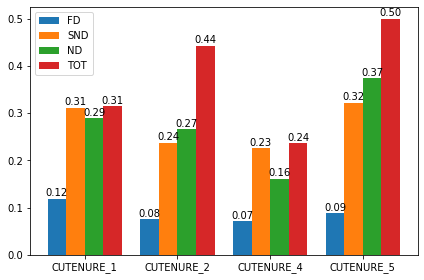

['nofin_cont1_treat1_CAT_3.csv']
['nofin_cont1_treat1_CAT_3.csv']
['nofin_cont1_treat1_CAT_3.csv']
['nofin_cont1_treat1_CAT_3.csv']


<Figure size 648x720 with 0 Axes>

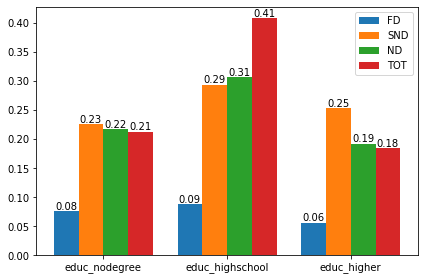

In [620]:
pdp_tuples = [('CAT_1','CUTENURE_'),('CAT_3','educ_')]
educ = ['nodegree','highschool','higher']

#path = os.getcwd()+f'\\pdp\\{cons}'

#pdp_list = os.listdir(path)
#print(pdp_list)
            #plot income
treatment = 'treat1'
control = 'cont1'
consumption = ['FD','SND','ND','TOT']
for t in pdp_tuples:
    pdp_car_dict = dict()
    for c in consumption:
        carvar_means = []
        path = os.getcwd()+f'\\pdp\\{c}'
        pdp_list = os.listdir(path)
        pdp_list = [p for p in pdp_list if  (p.split('_')[0]=='nofin') if p[-9:-4]==f'{t[0]}' if p.split('_')[1]==control if p.split('_')[2]==treatment] ##(p.split('_')[0]=='finit') |
        print(pdp_list)
        for p in pdp_list:
            pdp_plot = pd.read_csv(f'{path}\\{p}')
            catvars = [v for v in list(pdp_plot) if v[-6:]=='median' if v[0:3]=='mpc']
            labels = [v[4:-7] for v in catvars]
            catvars_val = [pdp_plot.loc[0,v] for v in catvars]
            catvars_tuples = list(zip(catvars,catvars_val))
            #print(catvars_tuples)
            pdp_car_dict[f'{c}_tuples'] = catvars_tuples
            pdp_car_dict[f'{c}_values'] = catvars_val
            #pdp_car_dict[f'{c}_rects'] = ax.bar(x - width/2, catvars_val, width, label=c)

                # Add some text for labels, title and custom x-axis tick labels, etc.



    fig = plt.figure(figsize=(9, 10))
    fig, ax = plt.subplots()
    width = 0.2
    x = np.arange(len(labels))
    #print(x-width/2)
    #print((x-width/2)/2)
    #print((x-width/2)/2+0.0875)
    pos = (x-width/2)-width
    #print(pos)
    for i,c in enumerate(consumption):
        #print(x-width/4)
        pdp_car_dict[f'{c}_rects'] = ax.bar(pos, pdp_car_dict[f'{c}_values'], width, label=c)
        pos = pos +width
        #print(pos)
        def autolabel(rects):
            """Attach a text label above each bar in *rects*, displaying its height."""
            for rect in rects:
                height = rect.get_height()
                ax.annotate('{:,.2f}'.format(height),
                            xy=(rect.get_x() + rect.get_width() / 2, height-0.005),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')


        autolabel(pdp_car_dict[f'{c}_rects'])
    #ax.set_ylabel('Scores')
    #ax.set_title('Scores by group and gender')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    fig.tight_layout()

    plt.show()

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['G1', 'G2', 'G3', 'G4', 'G5']
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Men')
rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


**2.7** Visualize tree (not done yet) 

In [ ]:
cons = ['FD_','SND']
check = [key for key in pds_keys if key[0:7] == 'pdp_' + cons[0]]
check

In [ ]:
#import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

In [ ]:
#pull out one tree from forest
tree = rf.estimators_[5]

#export image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = x_list, rounded = True, precision = 1 )
(graph, )= pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree_check.png')
